In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from utils import *
import pickle
import pandas

In [2]:
from importlib import reload
import utils
utils = reload(utils)

In [3]:
pd.set_option('display.max_rows', 100)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
infile = open('column_types_optimized','rb')
column_types_optimized = pickle.load(infile)
infile.close()

mailout_train = pd.read_csv('mailout_train.csv',index_col=0 ,dtype = column_types_optimized)

mailout_test = pd.read_csv('mailout_test.csv',index_col=0,dtype = column_types_optimized)

cleaned_mapping_df = pd.read_pickle('cleaned_mapping_df.pkl')
attr_by_info_lvl = pd.read_pickle('attr_by_info_lvl.pkl')

In [5]:
mailout_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float32(267), int16(1), int32(1), int64(1), int8(91), object(6)
memory usage: 50.4+ MB


In [6]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float32(267), int16(1), int32(1), int8(91), object(6)
memory usage: 49.9+ MB


In [22]:
mailout_train.drop(['LNR'],axis=1,inplace=True)
test_lnr = mailout_test.LNR
mailout_test.drop(['LNR'],axis=1,inplace=True)
response = mailout_train.RESPONSE
mailout_train.drop(['RESPONSE'],axis=1,inplace=True)

mailout = pd.concat([mailout_train,mailout_test],ignore_index=True)
mailout = rename_features(mailout,cleaned_mapping_df)

In [8]:
# mailout_custom = preprocessing_cluster_1(mailout.copy(),cleaned_mapping_df,attr_by_info_lvl)
# mailout_custom = preprocessing_cluster_2(mailout_custom.copy(),cleaned_mapping_df,attr_by_info_lvl)
# mailout_custom = xgb_imputer(mailout_custom.copy())
# mailout_custom = feature_engineering(mailout_custom.copy())
# pd.to_pickle(mailout_custom,'mailout_custom.pkl')

# Auto Sklearn

In [9]:
from autosklearn import classification as auto_clas
from autosklearn import metrics

Possible set intersection at position 3


In [10]:
mailout_enc = pd.get_dummies(mailout.drop(['EINGEFUEGT_AM'],axis=1))

train = mailout_enc.iloc[:len(mailout_train)].copy()
test = mailout_enc.iloc[len(mailout_train):].copy()


In [11]:
X_training, X_testing, y_training, y_testing = train_test_split( train,response,stratify=response, test_size=0.2, random_state = 1)

In [14]:
auto_ml = auto_clas.AutoSklearnClassifier(ml_memory_limit=3072*2)

In [15]:
auto_ml.fit(X_training.copy(), y_training.copy(),metric=metrics.roc_auc, dataset_name='customer_response')

AutoSklearnClassifier(delete_output_folder_after_terminate=True,
                      delete_tmp_folder_after_terminate=True,
                      disable_evaluator_output=False,
                      ensemble_memory_limit=1024, ensemble_nbest=50,
                      ensemble_size=50, exclude_estimators=None,
                      exclude_preprocessors=None, get_smac_object_callback=None,
                      include_estimators=None, include_preprocessors=None,
                      initial_configurations_via_metalearning=25,
                      logging_config=None, max_models_on_disc=50,
                      metadata_directory=None, ml_memory_limit=6144,
                      n_jobs=None, output_folder=None, per_run_time_limit=360,
                      resampling_strategy='holdout',
                      resampling_strategy_arguments=None, seed=1,
                      shared_mode=False, smac_scenario_args=None,
                      time_left_for_this_task=3600, tmp_folder=N

In [16]:
auto_ml.sprint_statistics()

'auto-sklearn results:\n  Dataset name: customer_response\n  Metric: roc_auc\n  Best validation score: 0.753763\n  Number of target algorithm runs: 50\n  Number of successful target algorithm runs: 35\n  Number of crashed target algorithm runs: 1\n  Number of target algorithms that exceeded the time limit: 6\n  Number of target algorithms that exceeded the memory limit: 8\n'

In [17]:
auto_ml.show_models()

"[(0.660000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'sgd', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:sgd:alpha': 5.730959175685882e-05, 'classifier:sgd:average': 'True', 'classifier:sgd:fit_intercept': 'True', 'classifier:sgd:learning_rate': 'invscaling', 'classifier:sgd:loss': 'squared_hinge', 'classifier:sgd:penalty': 'l1', 'classifier:sgd:tol': 0.00020765441090953262, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.01824444924377202, 'feature_preprocessor:extra_trees_preproc_for_classifi

In [18]:
y_hat = auto_ml.predict_proba(X_testing)
print("Accuracy score", metrics.roc_auc(y_testing, y_hat))

Accuracy score 0.7347024639237368


# Vtreat

dataframe prep with vtreat

In [11]:
import vtreat

In [12]:
train = mailout.iloc[:len(mailout_train)].copy()
test = mailout.iloc[len(mailout_train):].copy()

In [13]:
X_training, X_testing, y_training, y_testing = train_test_split( train,response,stratify=response, test_size=0.2, random_state = 1)

In [18]:
vtreat_data = X_training.copy()
vtreat_data['response'] = y_training

transform = vtreat.BinomialOutcomeTreatment(outcome_name='response')
treated_data = transform.fit_transform(vtreat_data, vtreat_data['response'])


In [19]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,R2,significance,vcount,default_threshold,recommended
0,AKT_DAT_KL_is_bad,AKT_DAT_KL,missing_indicator,False,True,-0.001865,0.000026,0.728229,273.0,0.000733,False
1,ALTER_HH_is_bad,ALTER_HH,missing_indicator,False,True,-0.001865,0.000026,0.728229,273.0,0.000733,False
2,ALTER_KIND1_is_bad,ALTER_KIND1,missing_indicator,False,True,0.004825,0.000186,0.355324,273.0,0.000733,False
3,ALTER_KIND2_is_bad,ALTER_KIND2,missing_indicator,False,True,0.000877,0.000006,0.869547,273.0,0.000733,False
4,ALTER_KIND3_is_bad,ALTER_KIND3,missing_indicator,False,True,-0.006180,0.000226,0.308099,273.0,0.000733,False
...,...,...,...,...,...,...,...,...,...,...,...
650,OST_WEST_KZ_logit_code,OST_WEST_KZ,logit_code,True,True,0.010713,0.000894,0.042823,6.0,0.033333,False
651,OST_WEST_KZ_prevalence_code,OST_WEST_KZ,prevalence_code,False,True,0.013800,0.001461,0.009632,6.0,0.033333,True
652,OST_WEST_KZ_lev_W,OST_WEST_KZ,indicator_code,False,True,0.013950,0.001493,0.008861,11.0,0.018182,True
653,OST_WEST_KZ_lev_O,OST_WEST_KZ,indicator_code,False,True,-0.014723,0.001751,0.004599,11.0,0.018182,True


In [73]:
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours
rus = RandomUnderSampler(0.1,random_state =2)
from imblearn import over_sampling as os 
smote = os.SMOTE(0.02,random_state=1,k_neighbors=11,n_jobs=-1)
from imblearn.combine import SMOTEENN,SMOTETomek
smotom = SMOTETomek(0.06,random_state=1,n_jobs=-1)

In [74]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

In [75]:
auc_list = []

# X_treated = treatedAU_data.drop(['response'],axis=1)
# y_treated = treated_data.response

X_treated,y_treated = smote.fit_resample(treated_data.drop(['response'],axis=1),treated_data.response)

for train_index, test_index in skf.split(X_treated, y_treated):
    
    eval_set  =(X_treated.iloc[test_index],y_treated.iloc[test_index])
#     params = {"scale_pos_weight":(y_treated.iloc[train_index]==0).sum()/y_treated.iloc[train_index].sum()}
    cb_model = run_cb_classifier(X_treated.iloc[train_index],y_treated.iloc[train_index],CV= True,eval_set = eval_set,eval_metric='AUC')
    one
    auc_list.append(cb_model.best_score_['validation']['AUC'])
    
np.mean(auc_list)

Learning rate set to 0.110587
0:	learn: 0.6145398	test: 0.5271178	best: 0.5271178 (0)	total: 38ms	remaining: 37.9s
1:	learn: 0.6847794	test: 0.5861125	best: 0.5861125 (1)	total: 74ms	remaining: 36.9s
2:	learn: 0.7847605	test: 0.7141927	best: 0.7141927 (2)	total: 112ms	remaining: 37.3s


3:	learn: 0.8077286	test: 0.7394655	best: 0.7394655 (3)	total: 158ms	remaining: 39.3s
4:	learn: 0.8074661	test: 0.7236094	best: 0.7394655 (3)	total: 206ms	remaining: 41s
5:	learn: 0.8319074	test: 0.7549669	best: 0.7549669 (5)	total: 237ms	remaining: 39.2s
6:	learn: 0.8296693	test: 0.7518098	best: 0.7549669 (5)	total: 266ms	remaining: 37.8s
7:	learn: 0.8285158	test: 0.7509314	best: 0.7549669 (5)	total: 296ms	remaining: 36.7s
8:	learn: 0.8276031	test: 0.7476985	best: 0.7549669 (5)	total: 317ms	remaining: 34.9s
9:	learn: 0.8334827	test: 0.7618845	best: 0.7618845 (9)	total: 348ms	remaining: 34.5s
10:	learn: 0.8391498	test: 0.7714209	best: 0.7714209 (10)	total: 379ms	remaining: 34.1s
11:	learn: 0.8438230	test: 0.7704234	best: 0.7714209 (10)	total: 418ms	remaining: 34.4s
12:	learn: 0.8465647	test: 0.7741751	best: 0.7741751 (12)	total: 450ms	remaining: 34.2s
13:	learn: 0.8469228	test: 0.7783612	best: 0.7783612 (13)	total: 479ms	remaining: 33.8s
14:	learn: 0.8514127	test: 0.7791096	best: 0.779

97:	learn: 0.8879648	test: 0.7794838	best: 0.7832280 (56)	total: 3.23s	remaining: 29.7s
98:	learn: 0.8879464	test: 0.7795466	best: 0.7832280 (56)	total: 3.26s	remaining: 29.7s
99:	learn: 0.8888701	test: 0.7801109	best: 0.7832280 (56)	total: 3.29s	remaining: 29.7s
100:	learn: 0.8889223	test: 0.7797773	best: 0.7832280 (56)	total: 3.31s	remaining: 29.5s
101:	learn: 0.8889206	test: 0.7800091	best: 0.7832280 (56)	total: 3.33s	remaining: 29.3s
102:	learn: 0.8889244	test: 0.7799365	best: 0.7832280 (56)	total: 3.36s	remaining: 29.3s
103:	learn: 0.8890892	test: 0.7803319	best: 0.7832280 (56)	total: 3.38s	remaining: 29.1s
104:	learn: 0.8891352	test: 0.7800448	best: 0.7832280 (56)	total: 3.41s	remaining: 29.1s
105:	learn: 0.8892725	test: 0.7798932	best: 0.7832280 (56)	total: 3.44s	remaining: 29s
106:	learn: 0.8893131	test: 0.7795953	best: 0.7832280 (56)	total: 3.46s	remaining: 28.9s
107:	learn: 0.8893110	test: 0.7796300	best: 0.7832280 (56)	total: 3.5s	remaining: 28.9s
108:	learn: 0.8894602	test:

2:	learn: 0.8016725	test: 0.7100375	best: 0.7100375 (2)	total: 91.6ms	remaining: 30.4s
3:	learn: 0.8236158	test: 0.7252140	best: 0.7252140 (3)	total: 126ms	remaining: 31.4s
4:	learn: 0.8478383	test: 0.7512937	best: 0.7512937 (4)	total: 159ms	remaining: 31.7s
5:	learn: 0.8470823	test: 0.7516424	best: 0.7516424 (5)	total: 192ms	remaining: 31.8s
6:	learn: 0.8418289	test: 0.7500385	best: 0.7516424 (5)	total: 222ms	remaining: 31.5s
7:	learn: 0.8436383	test: 0.7520974	best: 0.7520974 (7)	total: 252ms	remaining: 31.2s
8:	learn: 0.8461982	test: 0.7570394	best: 0.7570394 (8)	total: 283ms	remaining: 31.2s
9:	learn: 0.8535689	test: 0.7603793	best: 0.7603793 (9)	total: 314ms	remaining: 31.1s
10:	learn: 0.8556442	test: 0.7632499	best: 0.7632499 (10)	total: 345ms	remaining: 31s
11:	learn: 0.8552430	test: 0.7617415	best: 0.7632499 (10)	total: 376ms	remaining: 30.9s
12:	learn: 0.8587321	test: 0.7615718	best: 0.7632499 (10)	total: 406ms	remaining: 30.8s
13:	learn: 0.8604987	test: 0.7654997	best: 0.7654

103:	learn: 0.8905658	test: 0.7670895	best: 0.7691320 (73)	total: 2.89s	remaining: 24.9s
104:	learn: 0.8906091	test: 0.7671598	best: 0.7691320 (73)	total: 2.91s	remaining: 24.8s
105:	learn: 0.8905449	test: 0.7670546	best: 0.7691320 (73)	total: 2.94s	remaining: 24.8s
106:	learn: 0.8911966	test: 0.7675466	best: 0.7691320 (73)	total: 2.97s	remaining: 24.8s
107:	learn: 0.8914840	test: 0.7673262	best: 0.7691320 (73)	total: 3s	remaining: 24.8s
108:	learn: 0.8915855	test: 0.7675586	best: 0.7691320 (73)	total: 3.02s	remaining: 24.7s
109:	learn: 0.8917123	test: 0.7673862	best: 0.7691320 (73)	total: 3.05s	remaining: 24.7s
110:	learn: 0.8917120	test: 0.7674048	best: 0.7691320 (73)	total: 3.07s	remaining: 24.6s
111:	learn: 0.8917877	test: 0.7675324	best: 0.7691320 (73)	total: 3.1s	remaining: 24.6s
112:	learn: 0.8919892	test: 0.7674288	best: 0.7691320 (73)	total: 3.13s	remaining: 24.6s
113:	learn: 0.8919654	test: 0.7674201	best: 0.7691320 (73)	total: 3.16s	remaining: 24.6s
114:	learn: 0.8919846	tes

1:	learn: 0.6824394	test: 0.6125475	best: 0.6125475 (1)	total: 59.5ms	remaining: 29.7s
2:	learn: 0.7236398	test: 0.6234300	best: 0.6234300 (2)	total: 91.4ms	remaining: 30.4s
3:	learn: 0.8124587	test: 0.7409791	best: 0.7409791 (3)	total: 123ms	remaining: 30.5s
4:	learn: 0.8245060	test: 0.7433904	best: 0.7433904 (4)	total: 152ms	remaining: 30.3s
5:	learn: 0.8481130	test: 0.7787783	best: 0.7787783 (5)	total: 183ms	remaining: 30.4s
6:	learn: 0.8478351	test: 0.7771187	best: 0.7787783 (5)	total: 214ms	remaining: 30.3s
7:	learn: 0.8513663	test: 0.7787292	best: 0.7787783 (5)	total: 243ms	remaining: 30.1s
8:	learn: 0.8559844	test: 0.7836064	best: 0.7836064 (8)	total: 273ms	remaining: 30s
9:	learn: 0.8574765	test: 0.7798039	best: 0.7836064 (8)	total: 305ms	remaining: 30.2s
10:	learn: 0.8581908	test: 0.7795393	best: 0.7836064 (8)	total: 334ms	remaining: 30.1s
11:	learn: 0.8582080	test: 0.7827018	best: 0.7836064 (8)	total: 364ms	remaining: 30s
12:	learn: 0.8596101	test: 0.7809578	best: 0.7836064 (

102:	learn: 0.8900245	test: 0.7958757	best: 0.7970966 (74)	total: 3.1s	remaining: 27s
103:	learn: 0.8904073	test: 0.7957317	best: 0.7970966 (74)	total: 3.13s	remaining: 27s
104:	learn: 0.8906673	test: 0.7954883	best: 0.7970966 (74)	total: 3.16s	remaining: 27s
105:	learn: 0.8906169	test: 0.7954643	best: 0.7970966 (74)	total: 3.19s	remaining: 26.9s
106:	learn: 0.8905551	test: 0.7954240	best: 0.7970966 (74)	total: 3.22s	remaining: 26.8s
107:	learn: 0.8906585	test: 0.7953989	best: 0.7970966 (74)	total: 3.25s	remaining: 26.8s
108:	learn: 0.8906148	test: 0.7951616	best: 0.7970966 (74)	total: 3.28s	remaining: 26.8s
109:	learn: 0.8905730	test: 0.7951201	best: 0.7970966 (74)	total: 3.31s	remaining: 26.8s
110:	learn: 0.8908560	test: 0.7953492	best: 0.7970966 (74)	total: 3.34s	remaining: 26.7s
111:	learn: 0.8907987	test: 0.7952172	best: 0.7970966 (74)	total: 3.36s	remaining: 26.6s
112:	learn: 0.8907951	test: 0.7952139	best: 0.7970966 (74)	total: 3.38s	remaining: 26.5s
113:	learn: 0.8909620	test: 

0:	learn: 0.6927921	test: 0.7487998	best: 0.7487998 (0)	total: 31.5ms	remaining: 31.4s
1:	learn: 0.7952146	test: 0.8613107	best: 0.8613107 (1)	total: 62.5ms	remaining: 31.2s
2:	learn: 0.8108109	test: 0.8819213	best: 0.8819213 (2)	total: 94.3ms	remaining: 31.3s
3:	learn: 0.8072167	test: 0.8830890	best: 0.8830890 (3)	total: 118ms	remaining: 29.3s
4:	learn: 0.8047422	test: 0.8844111	best: 0.8844111 (4)	total: 148ms	remaining: 29.4s
5:	learn: 0.8074957	test: 0.8802905	best: 0.8844111 (4)	total: 178ms	remaining: 29.6s
6:	learn: 0.8098767	test: 0.8866425	best: 0.8866425 (6)	total: 210ms	remaining: 29.8s
7:	learn: 0.8144350	test: 0.8902729	best: 0.8902729 (7)	total: 241ms	remaining: 29.8s
8:	learn: 0.8175200	test: 0.8936597	best: 0.8936597 (8)	total: 271ms	remaining: 29.9s
9:	learn: 0.8164740	test: 0.8895228	best: 0.8936597 (8)	total: 303ms	remaining: 30s
10:	learn: 0.8189477	test: 0.8937409	best: 0.8937409 (10)	total: 333ms	remaining: 30s
11:	learn: 0.8196805	test: 0.8939110	best: 0.8939110 

95:	learn: 0.8568688	test: 0.9312915	best: 0.9313521 (94)	total: 2.58s	remaining: 24.3s
96:	learn: 0.8568767	test: 0.9312243	best: 0.9313521 (94)	total: 2.61s	remaining: 24.3s
97:	learn: 0.8569798	test: 0.9314128	best: 0.9314128 (97)	total: 2.64s	remaining: 24.3s
98:	learn: 0.8569944	test: 0.9313792	best: 0.9314128 (97)	total: 2.66s	remaining: 24.2s
99:	learn: 0.8571544	test: 0.9315428	best: 0.9315428 (99)	total: 2.69s	remaining: 24.2s
100:	learn: 0.8574580	test: 0.9315200	best: 0.9315428 (99)	total: 2.72s	remaining: 24.2s
101:	learn: 0.8574981	test: 0.9315580	best: 0.9315580 (101)	total: 2.74s	remaining: 24.1s
102:	learn: 0.8580671	test: 0.9319089	best: 0.9319089 (102)	total: 2.77s	remaining: 24.1s
103:	learn: 0.8581591	test: 0.9317789	best: 0.9319089 (102)	total: 2.8s	remaining: 24.1s
104:	learn: 0.8581859	test: 0.9317843	best: 0.9319089 (102)	total: 2.83s	remaining: 24.1s
105:	learn: 0.8583544	test: 0.9317053	best: 0.9319089 (102)	total: 2.86s	remaining: 24.1s
106:	learn: 0.8583512	

190:	learn: 0.8716364	test: 0.9345227	best: 0.9347448 (182)	total: 5.12s	remaining: 21.7s
191:	learn: 0.8726179	test: 0.9346874	best: 0.9347448 (182)	total: 5.15s	remaining: 21.7s
192:	learn: 0.8725708	test: 0.9347156	best: 0.9347448 (182)	total: 5.17s	remaining: 21.6s
193:	learn: 0.8726286	test: 0.9346842	best: 0.9347448 (182)	total: 5.2s	remaining: 21.6s
194:	learn: 0.8727945	test: 0.9347188	best: 0.9347448 (182)	total: 5.23s	remaining: 21.6s
195:	learn: 0.8728839	test: 0.9347188	best: 0.9347448 (182)	total: 5.26s	remaining: 21.6s
196:	learn: 0.8731139	test: 0.9347578	best: 0.9347578 (196)	total: 5.29s	remaining: 21.6s
197:	learn: 0.8733089	test: 0.9349268	best: 0.9349268 (197)	total: 5.32s	remaining: 21.6s
198:	learn: 0.8733618	test: 0.9348716	best: 0.9349268 (197)	total: 5.34s	remaining: 21.5s
199:	learn: 0.8735058	test: 0.9348845	best: 0.9349268 (197)	total: 5.37s	remaining: 21.5s
200:	learn: 0.8734878	test: 0.9348142	best: 0.9349268 (197)	total: 5.39s	remaining: 21.4s
201:	learn:

284:	learn: 0.8883878	test: 0.9361081	best: 0.9361081 (284)	total: 7.68s	remaining: 19.3s
285:	learn: 0.8884800	test: 0.9361828	best: 0.9361828 (285)	total: 7.71s	remaining: 19.3s
286:	learn: 0.8884955	test: 0.9361568	best: 0.9361828 (285)	total: 7.73s	remaining: 19.2s
287:	learn: 0.8884889	test: 0.9361546	best: 0.9361828 (285)	total: 7.75s	remaining: 19.2s
288:	learn: 0.8886896	test: 0.9361037	best: 0.9361828 (285)	total: 7.78s	remaining: 19.1s
289:	learn: 0.8888145	test: 0.9357592	best: 0.9361828 (285)	total: 7.81s	remaining: 19.1s
290:	learn: 0.8890522	test: 0.9357809	best: 0.9361828 (285)	total: 7.84s	remaining: 19.1s
291:	learn: 0.8891794	test: 0.9358351	best: 0.9361828 (285)	total: 7.87s	remaining: 19.1s
292:	learn: 0.8891810	test: 0.9358502	best: 0.9361828 (285)	total: 7.89s	remaining: 19s
293:	learn: 0.8899366	test: 0.9361449	best: 0.9361828 (285)	total: 7.92s	remaining: 19s
294:	learn: 0.8899351	test: 0.9361351	best: 0.9361828 (285)	total: 7.94s	remaining: 19s
295:	learn: 0.89

379:	learn: 0.9004444	test: 0.9381683	best: 0.9385128 (376)	total: 10.2s	remaining: 16.7s
380:	learn: 0.9004075	test: 0.9381781	best: 0.9385128 (376)	total: 10.3s	remaining: 16.7s
381:	learn: 0.9009163	test: 0.9382117	best: 0.9385128 (376)	total: 10.3s	remaining: 16.7s
382:	learn: 0.9009475	test: 0.9382518	best: 0.9385128 (376)	total: 10.3s	remaining: 16.6s
383:	learn: 0.9011846	test: 0.9382312	best: 0.9385128 (376)	total: 10.4s	remaining: 16.6s
384:	learn: 0.9013222	test: 0.9381781	best: 0.9385128 (376)	total: 10.4s	remaining: 16.6s
385:	learn: 0.9013458	test: 0.9382431	best: 0.9385128 (376)	total: 10.4s	remaining: 16.6s
386:	learn: 0.9013053	test: 0.9382972	best: 0.9385128 (376)	total: 10.4s	remaining: 16.5s
387:	learn: 0.9012862	test: 0.9382702	best: 0.9385128 (376)	total: 10.5s	remaining: 16.5s
388:	learn: 0.9013482	test: 0.9382648	best: 0.9385128 (376)	total: 10.5s	remaining: 16.5s
389:	learn: 0.9014656	test: 0.9384088	best: 0.9385128 (376)	total: 10.5s	remaining: 16.5s
390:	learn

477:	learn: 0.9087451	test: 0.9397076	best: 0.9401030 (455)	total: 12.8s	remaining: 14s
478:	learn: 0.9088445	test: 0.9397791	best: 0.9401030 (455)	total: 12.8s	remaining: 14s
479:	learn: 0.9087654	test: 0.9397867	best: 0.9401030 (455)	total: 12.9s	remaining: 13.9s
480:	learn: 0.9087750	test: 0.9398008	best: 0.9401030 (455)	total: 12.9s	remaining: 13.9s
481:	learn: 0.9088120	test: 0.9398300	best: 0.9401030 (455)	total: 12.9s	remaining: 13.9s
482:	learn: 0.9088398	test: 0.9397780	best: 0.9401030 (455)	total: 12.9s	remaining: 13.9s
483:	learn: 0.9088187	test: 0.9397748	best: 0.9401030 (455)	total: 13s	remaining: 13.8s
484:	learn: 0.9088903	test: 0.9396773	best: 0.9401030 (455)	total: 13s	remaining: 13.8s
485:	learn: 0.9088899	test: 0.9396654	best: 0.9401030 (455)	total: 13s	remaining: 13.8s
486:	learn: 0.9088277	test: 0.9396654	best: 0.9401030 (455)	total: 13s	remaining: 13.7s
487:	learn: 0.9088601	test: 0.9396383	best: 0.9401030 (455)	total: 13.1s	remaining: 13.7s
488:	learn: 0.9088348	

575:	learn: 0.9145449	test: 0.9404258	best: 0.9405406 (532)	total: 15.4s	remaining: 11.3s
576:	learn: 0.9145457	test: 0.9404030	best: 0.9405406 (532)	total: 15.4s	remaining: 11.3s
577:	learn: 0.9145761	test: 0.9403240	best: 0.9405406 (532)	total: 15.4s	remaining: 11.3s
578:	learn: 0.9145682	test: 0.9403012	best: 0.9405406 (532)	total: 15.4s	remaining: 11.2s
579:	learn: 0.9146051	test: 0.9403424	best: 0.9405406 (532)	total: 15.5s	remaining: 11.2s
580:	learn: 0.9145739	test: 0.9403435	best: 0.9405406 (532)	total: 15.5s	remaining: 11.2s
581:	learn: 0.9152616	test: 0.9407193	best: 0.9407193 (581)	total: 15.5s	remaining: 11.1s
582:	learn: 0.9152483	test: 0.9407042	best: 0.9407193 (581)	total: 15.5s	remaining: 11.1s
583:	learn: 0.9152132	test: 0.9406869	best: 0.9407193 (581)	total: 15.6s	remaining: 11.1s
584:	learn: 0.9152216	test: 0.9406836	best: 0.9407193 (581)	total: 15.6s	remaining: 11.1s
585:	learn: 0.9152597	test: 0.9407172	best: 0.9407193 (581)	total: 15.6s	remaining: 11s
586:	learn: 

672:	learn: 0.9222614	test: 0.9407063	best: 0.9414917 (654)	total: 18.3s	remaining: 8.91s
673:	learn: 0.9224250	test: 0.9407053	best: 0.9414917 (654)	total: 18.4s	remaining: 8.89s
674:	learn: 0.9224199	test: 0.9406782	best: 0.9414917 (654)	total: 18.4s	remaining: 8.86s
675:	learn: 0.9224093	test: 0.9406749	best: 0.9414917 (654)	total: 18.4s	remaining: 8.83s
676:	learn: 0.9224044	test: 0.9406684	best: 0.9414917 (654)	total: 18.5s	remaining: 8.8s
677:	learn: 0.9223906	test: 0.9406782	best: 0.9414917 (654)	total: 18.5s	remaining: 8.78s
678:	learn: 0.9224547	test: 0.9406554	best: 0.9414917 (654)	total: 18.5s	remaining: 8.76s
679:	learn: 0.9224266	test: 0.9406359	best: 0.9414917 (654)	total: 18.5s	remaining: 8.72s
680:	learn: 0.9226775	test: 0.9406175	best: 0.9414917 (654)	total: 18.6s	remaining: 8.7s
681:	learn: 0.9227116	test: 0.9406879	best: 0.9414917 (654)	total: 18.6s	remaining: 8.67s
682:	learn: 0.9227074	test: 0.9406814	best: 0.9414917 (654)	total: 18.6s	remaining: 8.64s
683:	learn: 

1:	learn: 0.6790460	test: 0.7678960	best: 0.7678960 (1)	total: 82.4ms	remaining: 41.1s
2:	learn: 0.6859112	test: 0.8065531	best: 0.8065531 (2)	total: 139ms	remaining: 46.3s
3:	learn: 0.7841552	test: 0.8823085	best: 0.8823085 (3)	total: 197ms	remaining: 49s
4:	learn: 0.7780815	test: 0.8815205	best: 0.8823085 (3)	total: 240ms	remaining: 47.8s
5:	learn: 0.7736749	test: 0.8752740	best: 0.8823085 (3)	total: 298ms	remaining: 49.3s
6:	learn: 0.7715021	test: 0.8733633	best: 0.8823085 (3)	total: 354ms	remaining: 50.2s
7:	learn: 0.7858169	test: 0.8790069	best: 0.8823085 (3)	total: 410ms	remaining: 50.9s
8:	learn: 0.8019840	test: 0.8912213	best: 0.8912213 (8)	total: 467ms	remaining: 51.4s
9:	learn: 0.8017732	test: 0.8901419	best: 0.8912213 (8)	total: 514ms	remaining: 50.9s
10:	learn: 0.8087034	test: 0.8981540	best: 0.8981540 (10)	total: 558ms	remaining: 50.1s
11:	learn: 0.8102993	test: 0.9018911	best: 0.9018911 (11)	total: 592ms	remaining: 48.8s
12:	learn: 0.8096763	test: 0.9002154	best: 0.901891

98:	learn: 0.8563909	test: 0.9436099	best: 0.9436099 (98)	total: 3.62s	remaining: 33s
99:	learn: 0.8565448	test: 0.9436381	best: 0.9436381 (99)	total: 3.65s	remaining: 32.8s
100:	learn: 0.8566131	test: 0.9438808	best: 0.9438808 (100)	total: 3.67s	remaining: 32.6s
101:	learn: 0.8572116	test: 0.9444462	best: 0.9444462 (101)	total: 3.7s	remaining: 32.6s
102:	learn: 0.8575917	test: 0.9445339	best: 0.9445339 (102)	total: 3.73s	remaining: 32.5s
103:	learn: 0.8579423	test: 0.9447116	best: 0.9447116 (103)	total: 3.76s	remaining: 32.4s
104:	learn: 0.8579981	test: 0.9447495	best: 0.9447495 (104)	total: 3.78s	remaining: 32.2s
105:	learn: 0.8579931	test: 0.9448307	best: 0.9448307 (105)	total: 3.8s	remaining: 32.1s
106:	learn: 0.8580512	test: 0.9448307	best: 0.9448307 (105)	total: 3.83s	remaining: 32s
107:	learn: 0.8580778	test: 0.9448362	best: 0.9448362 (107)	total: 3.85s	remaining: 31.8s
108:	learn: 0.8582056	test: 0.9443682	best: 0.9448362 (107)	total: 3.88s	remaining: 31.7s
109:	learn: 0.858596

196:	learn: 0.8771253	test: 0.9481952	best: 0.9486718 (195)	total: 6.68s	remaining: 27.2s
197:	learn: 0.8771262	test: 0.9481985	best: 0.9486718 (195)	total: 6.71s	remaining: 27.2s
198:	learn: 0.8771235	test: 0.9481963	best: 0.9486718 (195)	total: 6.75s	remaining: 27.2s
199:	learn: 0.8771315	test: 0.9481952	best: 0.9486718 (195)	total: 6.76s	remaining: 27.1s
200:	learn: 0.8780178	test: 0.9483079	best: 0.9486718 (195)	total: 6.79s	remaining: 27s
201:	learn: 0.8782507	test: 0.9484227	best: 0.9486718 (195)	total: 6.83s	remaining: 27s
202:	learn: 0.8782516	test: 0.9484227	best: 0.9486718 (195)	total: 6.85s	remaining: 26.9s
203:	learn: 0.8784570	test: 0.9484552	best: 0.9486718 (195)	total: 6.88s	remaining: 26.8s
204:	learn: 0.8784323	test: 0.9484715	best: 0.9486718 (195)	total: 6.89s	remaining: 26.7s
205:	learn: 0.8786305	test: 0.9484812	best: 0.9486718 (195)	total: 6.93s	remaining: 26.7s
206:	learn: 0.8786077	test: 0.9485094	best: 0.9486718 (195)	total: 6.96s	remaining: 26.7s
207:	learn: 0.

288:	learn: 0.8959431	test: 0.9508383	best: 0.9513106 (275)	total: 9.26s	remaining: 22.8s
289:	learn: 0.8961019	test: 0.9510398	best: 0.9513106 (275)	total: 9.29s	remaining: 22.8s
290:	learn: 0.8964151	test: 0.9512055	best: 0.9513106 (275)	total: 9.33s	remaining: 22.7s
291:	learn: 0.8964047	test: 0.9511871	best: 0.9513106 (275)	total: 9.36s	remaining: 22.7s
292:	learn: 0.8964818	test: 0.9511351	best: 0.9513106 (275)	total: 9.39s	remaining: 22.7s
293:	learn: 0.8965122	test: 0.9513312	best: 0.9513312 (293)	total: 9.42s	remaining: 22.6s
294:	learn: 0.8965221	test: 0.9512965	best: 0.9513312 (293)	total: 9.45s	remaining: 22.6s
295:	learn: 0.8966518	test: 0.9513929	best: 0.9513929 (295)	total: 9.48s	remaining: 22.6s
296:	learn: 0.8966428	test: 0.9513766	best: 0.9513929 (295)	total: 9.51s	remaining: 22.5s
297:	learn: 0.8969041	test: 0.9513215	best: 0.9513929 (295)	total: 9.53s	remaining: 22.5s
298:	learn: 0.8967665	test: 0.9510809	best: 0.9513929 (295)	total: 9.56s	remaining: 22.4s
299:	learn

381:	learn: 0.9112709	test: 0.9532268	best: 0.9533319 (376)	total: 12.3s	remaining: 20s
382:	learn: 0.9115843	test: 0.9532388	best: 0.9533319 (376)	total: 12.4s	remaining: 20s
383:	learn: 0.9118628	test: 0.9532788	best: 0.9533319 (376)	total: 12.5s	remaining: 20s
384:	learn: 0.9117979	test: 0.9532669	best: 0.9533319 (376)	total: 12.5s	remaining: 20s
385:	learn: 0.9120590	test: 0.9533091	best: 0.9533319 (376)	total: 12.6s	remaining: 20s
386:	learn: 0.9121487	test: 0.9533406	best: 0.9533406 (386)	total: 12.6s	remaining: 20s
387:	learn: 0.9121899	test: 0.9533623	best: 0.9533623 (387)	total: 12.7s	remaining: 20s
388:	learn: 0.9121968	test: 0.9533611	best: 0.9533623 (387)	total: 12.7s	remaining: 20s
389:	learn: 0.9125918	test: 0.9535106	best: 0.9535106 (389)	total: 12.8s	remaining: 20s
390:	learn: 0.9125949	test: 0.9535106	best: 0.9535106 (389)	total: 12.8s	remaining: 20s
391:	learn: 0.9127606	test: 0.9535799	best: 0.9535799 (391)	total: 12.9s	remaining: 20s
392:	learn: 0.9129749	test: 0.95

479:	learn: 0.9197559	test: 0.9541562	best: 0.9543426 (452)	total: 16.9s	remaining: 18.3s
480:	learn: 0.9197616	test: 0.9541714	best: 0.9543426 (452)	total: 16.9s	remaining: 18.2s
481:	learn: 0.9197540	test: 0.9541638	best: 0.9543426 (452)	total: 16.9s	remaining: 18.2s
482:	learn: 0.9197575	test: 0.9541368	best: 0.9543426 (452)	total: 16.9s	remaining: 18.1s
483:	learn: 0.9197526	test: 0.9541335	best: 0.9543426 (452)	total: 17s	remaining: 18.1s
484:	learn: 0.9201515	test: 0.9545679	best: 0.9545679 (484)	total: 17s	remaining: 18.1s
485:	learn: 0.9203008	test: 0.9546296	best: 0.9546296 (485)	total: 17s	remaining: 18s
486:	learn: 0.9203841	test: 0.9546090	best: 0.9546296 (485)	total: 17.1s	remaining: 18s
487:	learn: 0.9204086	test: 0.9546339	best: 0.9546339 (487)	total: 17.1s	remaining: 18s
488:	learn: 0.9205902	test: 0.9546253	best: 0.9546339 (487)	total: 17.2s	remaining: 17.9s
489:	learn: 0.9205562	test: 0.9545960	best: 0.9546339 (487)	total: 17.2s	remaining: 17.9s
490:	learn: 0.9210742	

577:	learn: 0.9284746	test: 0.9559468	best: 0.9560464 (562)	total: 20.6s	remaining: 15s
578:	learn: 0.9284692	test: 0.9559349	best: 0.9560464 (562)	total: 20.6s	remaining: 15s
579:	learn: 0.9284860	test: 0.9559555	best: 0.9560464 (562)	total: 20.6s	remaining: 14.9s
580:	learn: 0.9284926	test: 0.9559555	best: 0.9560464 (562)	total: 20.7s	remaining: 14.9s
581:	learn: 0.9284806	test: 0.9559338	best: 0.9560464 (562)	total: 20.7s	remaining: 14.9s
582:	learn: 0.9284957	test: 0.9559609	best: 0.9560464 (562)	total: 20.7s	remaining: 14.8s
583:	learn: 0.9286140	test: 0.9559912	best: 0.9560464 (562)	total: 20.7s	remaining: 14.8s
584:	learn: 0.9287993	test: 0.9560551	best: 0.9560551 (584)	total: 20.8s	remaining: 14.7s
585:	learn: 0.9289930	test: 0.9561732	best: 0.9561732 (585)	total: 20.8s	remaining: 14.7s
586:	learn: 0.9290299	test: 0.9561569	best: 0.9561732 (585)	total: 20.8s	remaining: 14.7s
587:	learn: 0.9290208	test: 0.9561060	best: 0.9561732 (585)	total: 20.9s	remaining: 14.6s
588:	learn: 0.

670:	learn: 0.9316449	test: 0.9564884	best: 0.9565707 (619)	total: 23.1s	remaining: 11.3s
671:	learn: 0.9315636	test: 0.9565274	best: 0.9565707 (619)	total: 23.2s	remaining: 11.3s
672:	learn: 0.9315518	test: 0.9565187	best: 0.9565707 (619)	total: 23.2s	remaining: 11.3s
673:	learn: 0.9315212	test: 0.9564451	best: 0.9565707 (619)	total: 23.2s	remaining: 11.2s
674:	learn: 0.9315267	test: 0.9564267	best: 0.9565707 (619)	total: 23.3s	remaining: 11.2s
675:	learn: 0.9314923	test: 0.9564169	best: 0.9565707 (619)	total: 23.3s	remaining: 11.2s
676:	learn: 0.9314830	test: 0.9564115	best: 0.9565707 (619)	total: 23.3s	remaining: 11.1s
677:	learn: 0.9315746	test: 0.9564429	best: 0.9565707 (619)	total: 23.3s	remaining: 11.1s
678:	learn: 0.9316453	test: 0.9564299	best: 0.9565707 (619)	total: 23.4s	remaining: 11s
679:	learn: 0.9316373	test: 0.9564310	best: 0.9565707 (619)	total: 23.4s	remaining: 11s
680:	learn: 0.9317770	test: 0.9565437	best: 0.9565707 (619)	total: 23.4s	remaining: 11s
681:	learn: 0.93

762:	learn: 0.9337594	test: 0.9570604	best: 0.9571503 (749)	total: 25.7s	remaining: 7.98s
763:	learn: 0.9337257	test: 0.9571058	best: 0.9571503 (749)	total: 25.7s	remaining: 7.95s
764:	learn: 0.9338101	test: 0.9570842	best: 0.9571503 (749)	total: 25.8s	remaining: 7.91s
765:	learn: 0.9338172	test: 0.9570799	best: 0.9571503 (749)	total: 25.8s	remaining: 7.88s
766:	learn: 0.9337796	test: 0.9571243	best: 0.9571503 (749)	total: 25.8s	remaining: 7.84s
767:	learn: 0.9338747	test: 0.9572716	best: 0.9572716 (767)	total: 25.8s	remaining: 7.81s
768:	learn: 0.9338738	test: 0.9572716	best: 0.9572716 (767)	total: 25.9s	remaining: 7.77s
769:	learn: 0.9339239	test: 0.9572802	best: 0.9572802 (769)	total: 25.9s	remaining: 7.74s
770:	learn: 0.9339646	test: 0.9573062	best: 0.9573062 (770)	total: 25.9s	remaining: 7.7s
771:	learn: 0.9340542	test: 0.9573019	best: 0.9573062 (770)	total: 26s	remaining: 7.66s
772:	learn: 0.9340445	test: 0.9573030	best: 0.9573062 (770)	total: 26s	remaining: 7.63s
773:	learn: 0.9

854:	learn: 0.9361853	test: 0.9579562	best: 0.9580006 (850)	total: 28.2s	remaining: 4.79s
855:	learn: 0.9361480	test: 0.9579454	best: 0.9580006 (850)	total: 28.2s	remaining: 4.75s
856:	learn: 0.9361591	test: 0.9578500	best: 0.9580006 (850)	total: 28.3s	remaining: 4.72s
857:	learn: 0.9362543	test: 0.9578652	best: 0.9580006 (850)	total: 28.3s	remaining: 4.68s
858:	learn: 0.9362890	test: 0.9578554	best: 0.9580006 (850)	total: 28.3s	remaining: 4.65s
859:	learn: 0.9363028	test: 0.9578251	best: 0.9580006 (850)	total: 28.4s	remaining: 4.62s
860:	learn: 0.9362680	test: 0.9578262	best: 0.9580006 (850)	total: 28.4s	remaining: 4.58s
861:	learn: 0.9362659	test: 0.9578186	best: 0.9580006 (850)	total: 28.4s	remaining: 4.55s
862:	learn: 0.9362645	test: 0.9578229	best: 0.9580006 (850)	total: 28.5s	remaining: 4.52s
863:	learn: 0.9363333	test: 0.9578024	best: 0.9580006 (850)	total: 28.5s	remaining: 4.48s
864:	learn: 0.9363085	test: 0.9577645	best: 0.9580006 (850)	total: 28.5s	remaining: 4.45s
865:	learn

951:	learn: 0.9391107	test: 0.9589138	best: 0.9589777 (942)	total: 31s	remaining: 1.56s
952:	learn: 0.9390323	test: 0.9589408	best: 0.9589777 (942)	total: 31s	remaining: 1.53s
953:	learn: 0.9390316	test: 0.9589387	best: 0.9589777 (942)	total: 31s	remaining: 1.5s
954:	learn: 0.9390690	test: 0.9589452	best: 0.9589777 (942)	total: 31.1s	remaining: 1.46s
955:	learn: 0.9391234	test: 0.9589679	best: 0.9589777 (942)	total: 31.1s	remaining: 1.43s
956:	learn: 0.9391196	test: 0.9589387	best: 0.9589777 (942)	total: 31.1s	remaining: 1.4s
957:	learn: 0.9393858	test: 0.9589354	best: 0.9589777 (942)	total: 31.1s	remaining: 1.36s
958:	learn: 0.9393087	test: 0.9589322	best: 0.9589777 (942)	total: 31.2s	remaining: 1.33s
959:	learn: 0.9393069	test: 0.9589322	best: 0.9589777 (942)	total: 31.2s	remaining: 1.3s
960:	learn: 0.9392777	test: 0.9588910	best: 0.9589777 (942)	total: 31.2s	remaining: 1.27s
961:	learn: 0.9392756	test: 0.9588910	best: 0.9589777 (942)	total: 31.3s	remaining: 1.24s
962:	learn: 0.93927

0.8499851822853088

In [76]:
# params = {"scale_pos_weight":(y_treated==0).sum()/y_treated.sum()}
cb_model = run_cb_classifier(X_treated,y_treated,eval_metric='AUC')

Learning rate set to 0.110587
0:	learn: 0.6177135	test: 0.6548986	best: 0.6548986 (0)	total: 36.1ms	remaining: 36.1s
1:	learn: 0.6683824	test: 0.7114499	best: 0.7114499 (1)	total: 75.8ms	remaining: 37.8s
2:	learn: 0.7801812	test: 0.7847210	best: 0.7847210 (2)	total: 112ms	remaining: 37.1s


3:	learn: 0.8194694	test: 0.8284915	best: 0.8284915 (3)	total: 150ms	remaining: 37.4s
4:	learn: 0.8060564	test: 0.8201855	best: 0.8284915 (3)	total: 191ms	remaining: 38s
5:	learn: 0.8190195	test: 0.8279998	best: 0.8284915 (3)	total: 227ms	remaining: 37.6s
6:	learn: 0.8232363	test: 0.8308320	best: 0.8308320 (6)	total: 265ms	remaining: 37.6s
7:	learn: 0.8259835	test: 0.8358477	best: 0.8358477 (7)	total: 294ms	remaining: 36.5s
8:	learn: 0.8263924	test: 0.8329418	best: 0.8358477 (7)	total: 315ms	remaining: 34.7s
9:	learn: 0.8294902	test: 0.8437665	best: 0.8437665 (9)	total: 346ms	remaining: 34.3s
10:	learn: 0.8313691	test: 0.8424462	best: 0.8437665 (9)	total: 380ms	remaining: 34.2s
11:	learn: 0.8353368	test: 0.8447591	best: 0.8447591 (11)	total: 410ms	remaining: 33.8s
12:	learn: 0.8366681	test: 0.8441786	best: 0.8447591 (11)	total: 441ms	remaining: 33.5s
13:	learn: 0.8371825	test: 0.8440118	best: 0.8447591 (11)	total: 472ms	remaining: 33.3s
14:	learn: 0.8431163	test: 0.8458807	best: 0.8458

102:	learn: 0.8667435	test: 0.8710392	best: 0.8710392 (102)	total: 2.92s	remaining: 25.4s
103:	learn: 0.8670235	test: 0.8710219	best: 0.8710392 (102)	total: 2.95s	remaining: 25.4s
104:	learn: 0.8670658	test: 0.8708768	best: 0.8710392 (102)	total: 2.98s	remaining: 25.4s
105:	learn: 0.8671559	test: 0.8709136	best: 0.8710392 (102)	total: 3.02s	remaining: 25.4s
106:	learn: 0.8671483	test: 0.8709591	best: 0.8710392 (102)	total: 3.05s	remaining: 25.4s
107:	learn: 0.8671254	test: 0.8709580	best: 0.8710392 (102)	total: 3.06s	remaining: 25.3s
108:	learn: 0.8671505	test: 0.8709623	best: 0.8710392 (102)	total: 3.1s	remaining: 25.3s
109:	learn: 0.8672278	test: 0.8709986	best: 0.8710392 (102)	total: 3.13s	remaining: 25.3s
110:	learn: 0.8675300	test: 0.8709623	best: 0.8710392 (102)	total: 3.16s	remaining: 25.3s
111:	learn: 0.8684410	test: 0.8715082	best: 0.8715082 (111)	total: 3.19s	remaining: 25.3s
112:	learn: 0.8684974	test: 0.8714378	best: 0.8715082 (111)	total: 3.21s	remaining: 25.2s
113:	learn:

200:	learn: 0.8845547	test: 0.8757349	best: 0.8765721 (190)	total: 5.66s	remaining: 22.5s
201:	learn: 0.8847221	test: 0.8757609	best: 0.8765721 (190)	total: 5.68s	remaining: 22.4s
202:	learn: 0.8847918	test: 0.8759590	best: 0.8765721 (190)	total: 5.72s	remaining: 22.5s
203:	learn: 0.8847778	test: 0.8759407	best: 0.8765721 (190)	total: 5.74s	remaining: 22.4s
204:	learn: 0.8849957	test: 0.8758377	best: 0.8765721 (190)	total: 5.77s	remaining: 22.4s
205:	learn: 0.8850104	test: 0.8757760	best: 0.8765721 (190)	total: 5.79s	remaining: 22.3s
206:	learn: 0.8850421	test: 0.8757598	best: 0.8765721 (190)	total: 5.81s	remaining: 22.3s
207:	learn: 0.8853711	test: 0.8758556	best: 0.8765721 (190)	total: 5.85s	remaining: 22.3s
208:	learn: 0.8853745	test: 0.8758459	best: 0.8765721 (190)	total: 5.87s	remaining: 22.2s
209:	learn: 0.8853567	test: 0.8758372	best: 0.8765721 (190)	total: 5.9s	remaining: 22.2s
210:	learn: 0.8853582	test: 0.8759217	best: 0.8765721 (190)	total: 5.92s	remaining: 22.1s
211:	learn:

299:	learn: 0.8965629	test: 0.8755924	best: 0.8777326 (249)	total: 8.42s	remaining: 19.7s
300:	learn: 0.8965645	test: 0.8755914	best: 0.8777326 (249)	total: 8.44s	remaining: 19.6s
301:	learn: 0.8965972	test: 0.8755426	best: 0.8777326 (249)	total: 8.47s	remaining: 19.6s
302:	learn: 0.8970694	test: 0.8757982	best: 0.8777326 (249)	total: 8.5s	remaining: 19.6s
303:	learn: 0.8970326	test: 0.8757527	best: 0.8777326 (249)	total: 8.53s	remaining: 19.5s
304:	learn: 0.8972131	test: 0.8757549	best: 0.8777326 (249)	total: 8.56s	remaining: 19.5s
305:	learn: 0.8973053	test: 0.8757766	best: 0.8777326 (249)	total: 8.59s	remaining: 19.5s
306:	learn: 0.8974470	test: 0.8753737	best: 0.8777326 (249)	total: 8.62s	remaining: 19.4s
307:	learn: 0.8975190	test: 0.8753899	best: 0.8777326 (249)	total: 8.65s	remaining: 19.4s
308:	learn: 0.8975188	test: 0.8753856	best: 0.8777326 (249)	total: 8.66s	remaining: 19.4s
309:	learn: 0.8975729	test: 0.8755134	best: 0.8777326 (249)	total: 8.7s	remaining: 19.4s
310:	learn: 

In [71]:
test_prepared = transform.transform(X_testing)

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_testing,cb_model.predict_proba(test_prepared)[:,1])

0.7381789240369844

# AUTO-GLUON

In [7]:
import autogluon as ag
from autogluon import TabularPrediction as task

In [8]:
train = mailout.iloc[:len(mailout_train)].copy()
test = mailout.iloc[len(mailout_train):].copy()

In [9]:
X_training, X_testing, y_training, y_testing = train_test_split( train,response,stratify=response, test_size=0.2, random_state = 1)

In [10]:
X_training['response'] = y_training
train_data = task.Dataset(X_training)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
eval_metric = 'roc_auc'
hyperparameters = {'CAT': {'scale_pos_weight':90}, 'GBM':  {'scale_pos_weight':90}}  # hyperparameters of each model type
predictor = task.fit(train_data=train_data, label='response',num_bagging_folds=5, stack_ensemble_levels=3, eval_metric=eval_metric,output_directory='autogluon')

Beginning AutoGluon training ...
AutoGluon will save models to autogluon/
Train Data Rows:    34369
Train Data Columns: 366
Preprocessing data ...
Here are the first 10 unique label values in your data:  [0 1]
AutoGluon infers your prediction problem is: binary  (because only two unique label-values observed).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: [('binary', 'multiclass', 'regression')])

Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Feature Generator processed 34369 data points with 365 features
Original Features:
	int features: 92
	float features: 267
	object features: 5
	datetime features: 1
Generated Features:
	int features: 0
All Features:
	int features: 92
	float features: 267
	object features: 5
	datetime features: 1
	Data preprocessing and feature engineering runtime = 4.01s ...
AutoGluon will gauge predictive performance using evaluation metric: roc_auc
This metric expects predicted pr

In [23]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer
0  CatboostClassifier_STACKER_l0   0.761396       0.336143   9.749294                0.336143           9.749294            0       True
1  CatboostClassifier_STACKER_l1   0.758712       1.041064  39.566862                0.346292           9.744045            1       True
2        weighted_ensemble_k0_l2   0.705795       1.409686  60.119426                0.007140           1.075615            2       True
3  LightGBMClassifier_STACKER_l1   0.692994       1.056254  49.299766                0.361482          19.476949            1       True
4        weighted_ensemble_k0_l1   0.689483       0.701682  30.911321                0.006910           1.088504            1       True
5  LightGBMClassifier_STACKER_l0   0.655183       0.358629  20.073523                0.358629          20.073523    

In [24]:
y_pred = predictor.predict_proba(X_testing)
print("Predictions:  ", y_pred)
perf = predictor.evaluate_predictions(y_true=y_testing, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: roc_auc on test data: 0.6838411021517926
Evaluations on test data:
{
    "roc_auc": 0.6838411021517926
}


Predictions:   [0.00486854 0.00439296 0.00429291 ... 0.04439589 0.00509268 0.48568732]


# Standard ETL

In [23]:
mailout = fill_unknowns_to_nan(mailout.copy(),cleaned_mapping_df)
mailout = minimal(mailout.copy(),cleaned_mapping_df)
miss = get_missing_cols(mailout)
cols_to_drop = miss[miss>20].index.tolist()
mailout.drop(cols_to_drop,axis=1,inplace=True)

mailout = fill_nan_to_unknowns(mailout.copy(),cleaned_mapping_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85795 entries, 0 to 85794
Columns: 360 entries, AGER_TYP to neighbourhood_class
dtypes: float32(259), float64(13), int16(1), int64(3), int8(84)
memory usage: 102.3 MB


None

optimizing...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85795 entries, 0 to 85794
Columns: 360 entries, AGER_TYP to neighbourhood_class
dtypes: float32(259), float64(13), int16(1), int8(87)
memory usage: 100.6 MB



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


None

In [24]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

### baseline before imputation

https://www.kaggle.com/general/7517

In [25]:
auc_list = []
X_base = mailout.iloc[:len(mailout_train)]
for train_index, test_index in skf.split(X_base, response):
    eval_set  =(X_base.iloc[test_index],response.iloc[test_index])
    params = {"scale_pos_weight":99}
    xgb_model = run_xgb_classifier(X_base.iloc[train_index],response.iloc[train_index],CV= True,eval_set = eval_set,eval_metric=['auc'],params=params)
    auc_list.append(xgb_model.best_score)
np.mean(auc_list)
# 0.7556533999999999

[0]	validation_0-auc:0.703325
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.70303
[2]	validation_0-auc:0.702107
[3]	validation_0-auc:0.70295
[4]	validation_0-auc:0.704454
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.708126
[7]	validation_0-auc:0.70859
[8]	validation_0-auc:0.708549
[9]	validation_0-auc:0.709291
[10]	validation_0-auc:0.71049
[11]	validation_0-auc:0.711938
[12]	validation_0-auc:0.710611
[13]	validation_0-auc:0.707894
[14]	validation_0-auc:0.743843
[15]	validation_0-auc:0.741925
[16]	validation_0-auc:0.74324
[17]	validation_0-auc:0.742871
[18]	validation_0-auc:0.742236
[19]	validation_0-auc:0.742118
[20]	validation_0-auc:0.74242
[21]	validation_0-auc:0.742175
[22]	validation_0-auc:0.743139
[23]	validation_0-auc:0.745249
[24]	validation_0-auc:0.745933
[25]	validation_0-auc:0.745871
[26]	validation_0-auc:0.746267
[27]	validation_0-auc:0.746545
[28]	validation_0-auc:0.746693
[29]	validation_0-auc:0.745735
[30]	validation_0-auc:

[129]	validation_0-auc:0.691952
[130]	validation_0-auc:0.692414
[131]	validation_0-auc:0.691857
[132]	validation_0-auc:0.691215
[133]	validation_0-auc:0.68845
[134]	validation_0-auc:0.68999
[135]	validation_0-auc:0.689245
[136]	validation_0-auc:0.687675
[137]	validation_0-auc:0.688094
[138]	validation_0-auc:0.68606
[139]	validation_0-auc:0.685682
[140]	validation_0-auc:0.685286
[141]	validation_0-auc:0.684373
[142]	validation_0-auc:0.684893
[143]	validation_0-auc:0.684582
[144]	validation_0-auc:0.681282
[145]	validation_0-auc:0.680393
[146]	validation_0-auc:0.67976
[147]	validation_0-auc:0.677166
[148]	validation_0-auc:0.678303
[149]	validation_0-auc:0.67848
[150]	validation_0-auc:0.677193
[151]	validation_0-auc:0.676335
[152]	validation_0-auc:0.674208
Stopping. Best iteration:
[52]	validation_0-auc:0.752865

[0]	validation_0-auc:0.631629
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.631322
[2]	validation_0-auc:0.709881
[3]	validation_0-auc:0.7

[70]	validation_0-auc:0.730213
[71]	validation_0-auc:0.729113
[72]	validation_0-auc:0.728528
[73]	validation_0-auc:0.727766
[74]	validation_0-auc:0.72763
[75]	validation_0-auc:0.727276
[76]	validation_0-auc:0.728601
[77]	validation_0-auc:0.728443
[78]	validation_0-auc:0.728468
[79]	validation_0-auc:0.726659
[80]	validation_0-auc:0.72674
[81]	validation_0-auc:0.725496
[82]	validation_0-auc:0.725387
[83]	validation_0-auc:0.726564
[84]	validation_0-auc:0.72355
[85]	validation_0-auc:0.723634
[86]	validation_0-auc:0.723867
[87]	validation_0-auc:0.724956
[88]	validation_0-auc:0.725604
[89]	validation_0-auc:0.726425
[90]	validation_0-auc:0.724868
[91]	validation_0-auc:0.725341
[92]	validation_0-auc:0.726671
[93]	validation_0-auc:0.727819
[94]	validation_0-auc:0.728639
[95]	validation_0-auc:0.730267
[96]	validation_0-auc:0.731914
[97]	validation_0-auc:0.730526
[98]	validation_0-auc:0.730108
[99]	validation_0-auc:0.7309
[100]	validation_0-auc:0.732137
[101]	validation_0-auc:0.732814
[102]	valid

0.7556533999999999

In [28]:
from fancyimpute import IterativeImputer
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
# mailout = xgb_imputer(mailout.copy(),0)

imputer = IterativeImputer(RidgeClassifier(),n_nearest_features=5,max_iter=100,random_state=1,add_indicator= True,initial_strategy='most_frequent')
mailout[mailout.columns] = imputer.fit_transform(mailout.values)

[IterativeImputer] Early stopping criterion not reached.


ValueError: Must have equal len keys and value when setting with an ndarray

In [32]:
mailout_imputed = imputer.transform(mailout.values)

### baseline after imputation

In [ ]:
auc_list = []
X_base = pd.DataFrame(mailout_imputed).iloc[:len(mailout_train)]
for train_index, test_index in skf.split(X_base, response):
    eval_set  =(X_base.iloc[test_index],response.iloc[test_index])
    params = {"scale_pos_weight":99}
    xgb_model = run_xgb_classifier(X_base.iloc[train_index],response.iloc[train_index],CV= True,eval_set = eval_set,eval_metric=['auc'],params=params)
    auc_list.append(xgb_model.best_score)
np.mean(auc_list)

[0]	validation_0-auc:0.621721
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.621409
[2]	validation_0-auc:0.726276
[3]	validation_0-auc:0.727334
[4]	validation_0-auc:0.729205
[5]	validation_0-auc:0.729253
[6]	validation_0-auc:0.730333
[7]	validation_0-auc:0.731398
[8]	validation_0-auc:0.730407
[9]	validation_0-auc:0.730242
[10]	validation_0-auc:0.733952
[11]	validation_0-auc:0.737814
[12]	validation_0-auc:0.73935
[13]	validation_0-auc:0.737873
[14]	validation_0-auc:0.739075
[15]	validation_0-auc:0.739107
[16]	validation_0-auc:0.741431
[17]	validation_0-auc:0.736465
[18]	validation_0-auc:0.735631
[19]	validation_0-auc:0.736111
[20]	validation_0-auc:0.735121
[21]	validation_0-auc:0.735552
[22]	validation_0-auc:0.736434
[23]	validation_0-auc:0.737111
[24]	validation_0-auc:0.738673
[25]	validation_0-auc:0.73852
[26]	validation_0-auc:0.739033
[27]	validation_0-auc:0.740564
[28]	validation_0-auc:0.741317
[29]	validation_0-auc:0.743314
[30]	validation_0

In [14]:
display(mailout.info())
mailout = optimize(mailout,'')
display(mailout.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85795 entries, 0 to 85794
Columns: 283 entries, AKT_DAT_KL to neighbourhood_class
dtypes: float32(283)
memory usage: 92.6 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85795 entries, 0 to 85794
Columns: 283 entries, AKT_DAT_KL to neighbourhood_class
dtypes: int16(1), int8(282)
memory usage: 23.2 MB


None

In [15]:
pd.to_pickle(mailout,'mailout.pkl')
pd.to_pickle(response,'response.pkl')

In [77]:
mailout = pd.read_pickle('mailout.pkl')
response = pd.read_pickle('response.pkl')
mailout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85795 entries, 0 to 85794
Columns: 283 entries, AKT_DAT_KL to neighbourhood_class
dtypes: int16(1), int8(282)
memory usage: 23.2 MB


In [78]:
train = mailout.iloc[:len(mailout_train)].copy()
test = mailout.iloc[len(mailout_train):].copy()

In [79]:
train.shape,test.shape

((42962, 283), (42833, 283))

In [80]:
X_training, X_testing, y_training, y_testing = train_test_split( train,response,stratify=response, test_size=0.2, random_state = 1)

# FAST.AI

In [28]:
from fastai.tabular import *
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [29]:
smote = SMOTE()
X_os, y_os = smote.fit_sample(X_training, y_training)

In [30]:
from sklearn.preprocessing import MinMaxScaler
mmScaler= MinMaxScaler()

X_os[X_os.columns] = mmScaler.fit_transform(X_os)
X_os['target'] = y_os
y_os.sum(),y_os.shape

(33943, (67886,))

In [31]:
X_testing[X_testing.columns] = mmScaler.transform(X_testing)
X_testing['target'] = y_testing


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
idx = np.arange(X_os.shape[0])
train_set, valid_set, train_idx, valid_idx = train_test_split(X_os, idx, test_size=0.2, random_state=1)
train_idx.shape, valid_idx.shape

((54308,), (13578,))

In [33]:
cat_names = []
data = TabularDataBunch.from_df('.', X_os, 'target', valid_idx=valid_idx, cat_names=cat_names,test_df = X_testing )

In [34]:
learn = tabular_learner(data, layers=[500, 500,500,1000], emb_szs={}, metrics=[])

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


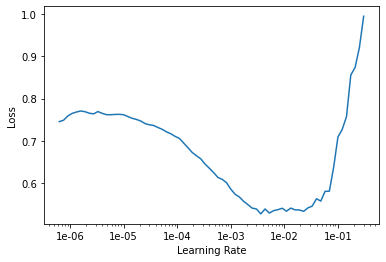

In [35]:
learn.lr_find(stop_div=True, num_it=100)
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.157840,0.135533,00:07


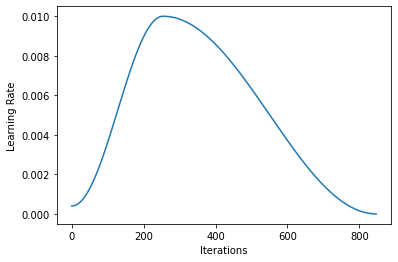

In [37]:
learn.recorder.plot_lr()

0.9876715792597848

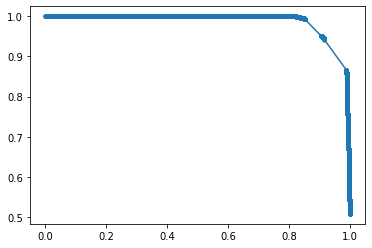

In [38]:
[train_preds, train_targets] = learn.get_preds(ds_type=DatasetType.Train)
train_preds = to_np(train_preds)[:,1]
train_targets = to_np(train_targets)

precision, recall, thresholds = precision_recall_curve(train_targets, train_preds)
plt.plot(recall, precision, marker='.')
auprc = auc(recall, precision)
auprc

0.9879957043343447

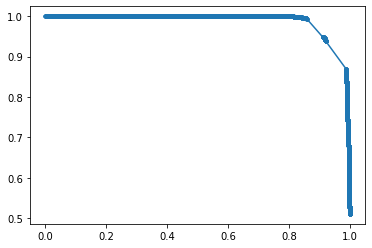

In [39]:
[valid_preds, valid_targets] = learn.get_preds(ds_type=DatasetType.Valid)
valid_preds = to_np(valid_preds)[:,1]
valid_targets = to_np(valid_targets)

precision, recall, thresholds = precision_recall_curve(valid_targets, valid_preds)
plt.plot(recall, precision, marker='.')
auprc = auc(recall, precision)
auprc

0.014598204940388784

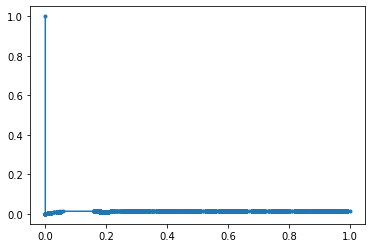

In [40]:
[test_preds, test_targets] = learn.get_preds(ds_type=DatasetType.Test)
test_preds = to_np(test_preds)[:,1]
test_targets = y_testing

precision, recall, thresholds = precision_recall_curve(test_targets, test_preds)
plt.plot(recall, precision, marker='.')
auprc = auc(recall, precision)
auprc

### Feature selection

Learning rate set to 0.110503
0:	learn: 0.7384374	test: 0.6536811	best: 0.6536811 (0)	total: 53.5ms	remaining: 53.5s
1:	learn: 0.7583712	test: 0.6572630	best: 0.6572630 (1)	total: 103ms	remaining: 51.6s
2:	learn: 0.7622792	test: 0.6731841	best: 0.6731841 (2)	total: 145ms	remaining: 48.1s
3:	learn: 0.7810036	test: 0.6467469	best: 0.6731841 (2)	total: 190ms	remaining: 47.2s
4:	learn: 0.7927651	test: 0.6331219	best: 0.6731841 (2)	total: 226ms	remaining: 44.9s
5:	learn: 0.7943894	test: 0.6365635	best: 0.6731841 (2)	total: 260ms	remaining: 43.1s
6:	learn: 0.8096843	test: 0.6515861	best: 0.6731841 (2)	total: 294ms	remaining: 41.7s
7:	learn: 0.8159668	test: 0.6448520	best: 0.6731841 (2)	total: 327ms	remaining: 40.6s
8:	learn: 0.8168773	test: 0.6447471	best: 0.6731841 (2)	total: 361ms	remaining: 39.8s
9:	learn: 0.8254547	test: 0.6421798	best: 0.6731841 (2)	total: 397ms	remaining: 39.3s
10:	learn: 0.8284402	test: 0.6461300	best: 0.6731841 (2)	total: 430ms	remaining: 38.7s
11:	learn: 0.8311990	t

102:	learn: 0.8802143	test: 0.6555371	best: 0.6731841 (2)	total: 2.81s	remaining: 24.5s
bestTest = 0.6731841266
bestIteration = 2
Shrink model to first 3 iterations.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


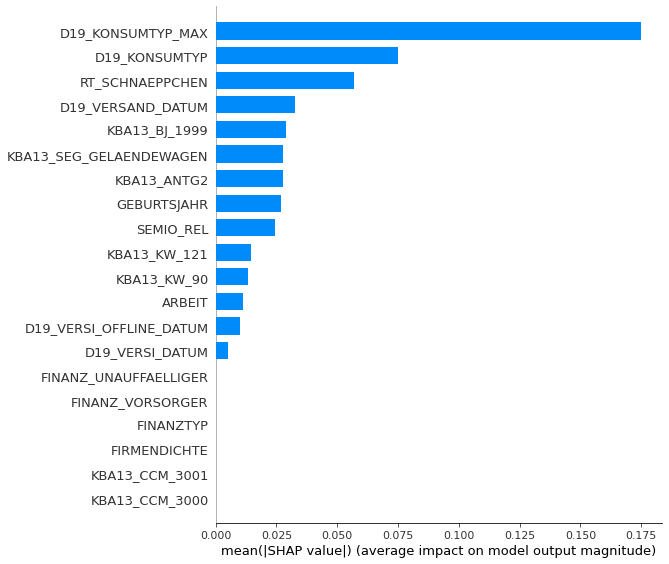

In [20]:
# using catboost from here 
_,feat_imp,cb = run_cb_classifier(X_training.drop(['D19_SOZIALES'],axis=1),y_training,shap=True,eval_metric='AUC',params={'scale_pos_weight':99})

In [21]:
feat_im_df = pd.DataFrame(list(zip(cb.feature_importances_,X_training.columns)),columns = ['importance','feature'] ).sort_values(by='importance',ascending=False)
internal_imp_feats = feat_im_df.loc[feat_im_df.importance>0].feature.tolist()
shap_imp_feats = feat_imp.col_name.tolist()

In [23]:
shap_imp_feats

['D19_KONSUMTYP_MAX',
 'D19_KONSUMTYP',
 'RT_SCHNAEPPCHEN',
 'D19_VERSAND_DATUM',
 'KBA13_BJ_1999',
 'KBA13_SEG_GELAENDEWAGEN',
 'KBA13_ANTG2',
 'GEBURTSJAHR',
 'SEMIO_REL',
 'KBA13_KW_121',
 'KBA13_KW_90',
 'ARBEIT',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_DATUM']

In [31]:
auc_list = []
X_base = mailout.iloc[:len(mailout_train)][internal_imp_feats]
for train_index, test_index in skf.split(X_base, response):
    eval_set  =(X_base.iloc[test_index],response.iloc[test_index])
    params = {"scale_pos_weight":99}
    cb = run_cb_classifier(X_base.iloc[train_index],response.iloc[train_index],CV= True,eval_set = eval_set,eval_metric='AUC',params=params)
    auc_list.append(cb.best_score_['validation']['AUC'])
np.mean(auc_list)

Learning rate set to 0.113122
0:	learn: 0.7235494	test: 0.6391957	best: 0.6391957 (0)	total: 29.1ms	remaining: 29.1s
1:	learn: 0.7391498	test: 0.6337860	best: 0.6391957 (0)	total: 65.6ms	remaining: 32.8s
2:	learn: 0.7413671	test: 0.6294072	best: 0.6391957 (0)	total: 102ms	remaining: 34s
3:	learn: 0.7429598	test: 0.6389810	best: 0.6391957 (0)	total: 146ms	remaining: 36.4s
4:	learn: 0.7464266	test: 0.6458901	best: 0.6458901 (4)	total: 189ms	remaining: 37.5s
5:	learn: 0.7433608	test: 0.6445718	best: 0.6458901 (4)	total: 223ms	remaining: 36.9s
6:	learn: 0.7446077	test: 0.6440548	best: 0.6458901 (4)	total: 252ms	remaining: 35.7s
7:	learn: 0.7473057	test: 0.6424815	best: 0.6458901 (4)	total: 282ms	remaining: 34.9s
8:	learn: 0.7596754	test: 0.6527084	best: 0.6527084 (8)	total: 313ms	remaining: 34.5s
9:	learn: 0.7604067	test: 0.6532485	best: 0.6532485 (9)	total: 332ms	remaining: 32.9s
10:	learn: 0.7605694	test: 0.6535310	best: 0.6535310 (10)	total: 361ms	remaining: 32.5s
11:	learn: 0.7607266	t

101:	learn: 0.7689031	test: 0.6413670	best: 0.6546175 (17)	total: 2.26s	remaining: 19.9s
102:	learn: 0.7689031	test: 0.6413670	best: 0.6546175 (17)	total: 2.28s	remaining: 19.9s
103:	learn: 0.7689031	test: 0.6413670	best: 0.6546175 (17)	total: 2.3s	remaining: 19.8s
104:	learn: 0.7709809	test: 0.6397844	best: 0.6546175 (17)	total: 2.33s	remaining: 19.9s
105:	learn: 0.7724394	test: 0.6387679	best: 0.6546175 (17)	total: 2.36s	remaining: 19.9s
106:	learn: 0.7723956	test: 0.6383912	best: 0.6546175 (17)	total: 2.39s	remaining: 19.9s
107:	learn: 0.7724097	test: 0.6383824	best: 0.6546175 (17)	total: 2.42s	remaining: 20s
108:	learn: 0.7772468	test: 0.6357073	best: 0.6546175 (17)	total: 2.45s	remaining: 20s
109:	learn: 0.7773163	test: 0.6356963	best: 0.6546175 (17)	total: 2.47s	remaining: 20s
110:	learn: 0.7773279	test: 0.6356864	best: 0.6546175 (17)	total: 2.48s	remaining: 19.9s
111:	learn: 0.7773825	test: 0.6357459	best: 0.6546175 (17)	total: 2.5s	remaining: 19.9s
112:	learn: 0.7774667	test: 0

87:	learn: 0.7497143	test: 0.7091053	best: 0.7119769 (57)	total: 1.77s	remaining: 18.3s
88:	learn: 0.7524691	test: 0.7086135	best: 0.7119769 (57)	total: 1.8s	remaining: 18.4s
89:	learn: 0.7529745	test: 0.7083007	best: 0.7119769 (57)	total: 1.82s	remaining: 18.4s
90:	learn: 0.7529745	test: 0.7083007	best: 0.7119769 (57)	total: 1.84s	remaining: 18.4s
91:	learn: 0.7529745	test: 0.7083007	best: 0.7119769 (57)	total: 1.87s	remaining: 18.4s
92:	learn: 0.7529745	test: 0.7083007	best: 0.7119769 (57)	total: 1.88s	remaining: 18.4s
93:	learn: 0.7529745	test: 0.7083007	best: 0.7119769 (57)	total: 1.9s	remaining: 18.3s
94:	learn: 0.7531850	test: 0.7080695	best: 0.7119769 (57)	total: 1.92s	remaining: 18.3s
95:	learn: 0.7527482	test: 0.7082060	best: 0.7119769 (57)	total: 1.94s	remaining: 18.3s
96:	learn: 0.7527394	test: 0.7081818	best: 0.7119769 (57)	total: 1.97s	remaining: 18.3s
97:	learn: 0.7527394	test: 0.7081818	best: 0.7119769 (57)	total: 1.98s	remaining: 18.3s
98:	learn: 0.7527394	test: 0.70818

27:	learn: 0.7357299	test: 0.7456993	best: 0.7482068 (19)	total: 668ms	remaining: 23.2s
28:	learn: 0.7357301	test: 0.7456993	best: 0.7482068 (19)	total: 686ms	remaining: 23s
29:	learn: 0.7357303	test: 0.7457005	best: 0.7482068 (19)	total: 703ms	remaining: 22.7s
30:	learn: 0.7353196	test: 0.7462875	best: 0.7482068 (19)	total: 721ms	remaining: 22.5s
31:	learn: 0.7353197	test: 0.7462885	best: 0.7482068 (19)	total: 738ms	remaining: 22.3s
32:	learn: 0.7353197	test: 0.7462885	best: 0.7482068 (19)	total: 756ms	remaining: 22.1s
33:	learn: 0.7353209	test: 0.7462908	best: 0.7482068 (19)	total: 774ms	remaining: 22s
34:	learn: 0.7353209	test: 0.7462908	best: 0.7482068 (19)	total: 791ms	remaining: 21.8s
35:	learn: 0.7359465	test: 0.7472213	best: 0.7482068 (19)	total: 808ms	remaining: 21.6s
36:	learn: 0.7359473	test: 0.7472246	best: 0.7482068 (19)	total: 827ms	remaining: 21.5s
37:	learn: 0.7359473	test: 0.7472246	best: 0.7482068 (19)	total: 843ms	remaining: 21.3s
38:	learn: 0.7359478	test: 0.7472246

129:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.57s	remaining: 17.2s
130:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.59s	remaining: 17.2s
131:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.6s	remaining: 17.1s
132:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.62s	remaining: 17.1s
133:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.64s	remaining: 17.1s
134:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.65s	remaining: 17s
135:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.67s	remaining: 17s
136:	learn: 0.7453160	test: 0.7477599	best: 0.7489428 (70)	total: 2.69s	remaining: 16.9s
137:	learn: 0.7453535	test: 0.7477555	best: 0.7489428 (70)	total: 2.71s	remaining: 16.9s
138:	learn: 0.7453535	test: 0.7477555	best: 0.7489428 (70)	total: 2.73s	remaining: 16.9s
139:	learn: 0.7453535	test: 0.7477555	best: 0.7489428 (70)	total: 2.74s	remaining: 16.8s
140:	learn: 0.7453535	test

53:	learn: 0.7474896	test: 0.6865681	best: 0.6894246 (1)	total: 1.11s	remaining: 19.5s
54:	learn: 0.7474896	test: 0.6865681	best: 0.6894246 (1)	total: 1.13s	remaining: 19.4s
55:	learn: 0.7474896	test: 0.6865681	best: 0.6894246 (1)	total: 1.15s	remaining: 19.4s
56:	learn: 0.7474896	test: 0.6865681	best: 0.6894246 (1)	total: 1.17s	remaining: 19.3s
57:	learn: 0.7474896	test: 0.6865681	best: 0.6894246 (1)	total: 1.18s	remaining: 19.2s
58:	learn: 0.7474896	test: 0.6865681	best: 0.6894246 (1)	total: 1.2s	remaining: 19.1s
59:	learn: 0.7474896	test: 0.6865692	best: 0.6894246 (1)	total: 1.22s	remaining: 19.1s
60:	learn: 0.7474896	test: 0.6865692	best: 0.6894246 (1)	total: 1.23s	remaining: 19s
61:	learn: 0.7474896	test: 0.6865692	best: 0.6894246 (1)	total: 1.25s	remaining: 18.9s
62:	learn: 0.7474896	test: 0.6865692	best: 0.6894246 (1)	total: 1.27s	remaining: 18.9s
63:	learn: 0.7474896	test: 0.6865692	best: 0.6894246 (1)	total: 1.28s	remaining: 18.8s
64:	learn: 0.7474896	test: 0.6865692	best: 0.6

52:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.07s	remaining: 19.2s
53:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.09s	remaining: 19.1s
54:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.11s	remaining: 19.1s
55:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.13s	remaining: 19s
56:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.15s	remaining: 18.9s
57:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.16s	remaining: 18.9s
58:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.18s	remaining: 18.8s
59:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.2s	remaining: 18.7s
60:	learn: 0.7461423	test: 0.6900133	best: 0.6960493 (5)	total: 1.21s	remaining: 18.7s
61:	learn: 0.7456074	test: 0.6899733	best: 0.6960493 (5)	total: 1.23s	remaining: 18.6s
62:	learn: 0.7470393	test: 0.6906047	best: 0.6960493 (5)	total: 1.25s	remaining: 18.6s
63:	learn: 0.7470393	test: 0.6906047	best: 0.6

0.700202226638794

## Modeling

In [32]:
train.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HH_TITEL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,generation,HH_family_type,area_type,neighbourhood_class
0,1,8,0,0,4,0,3,5,5,2,...,2,1,9,3,3,2,1,4,0,3
1,4,13,0,0,1,0,2,5,5,2,...,2,1,9,7,1,2,4,2,1,0
2,1,9,0,0,1,0,4,1,2,4,...,4,2,9,2,3,1,1,4,0,2
3,1,6,0,0,3,0,4,2,2,2,...,11,11,9,1,3,2,1,4,0,1
4,1,9,0,0,4,0,3,4,7,6,...,2,1,9,3,3,1,2,1,0,3


In [81]:
X_training, X_testing, y_training, y_testing = train_test_split(train,response,stratify=response, test_size=0.2, random_state = 1)

In [82]:
len(y_testing)+len(y_training),len(response)

(42962, 42962)

In [59]:
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours
from imblearn import over_sampling as os 
from imblearn.combine import SMOTEENN,SMOTETomek


rus = RandomUnderSampler(0.1,random_state =2)
eeus = EditedNearestNeighbours('majority',kind_sel='mode',n_neighbors=7,n_jobs=-1)

smote = os.SMOTE(random_state=1,n_jobs=-1)
ros = os.KMeansSMOTE(random_state =1,cluster_balance_threshold=0.01)

smoteen = SMOTEENN(0.06,random_state=1,n_jobs=-1)
smotom = SMOTETomek(0.06,random_state=1,n_jobs=-1)

In [60]:
# x_rus,y_rus = rus.fit_resample(X_train,y_train)
# x_eeus,y_eeus = eeus.fit_resample(X_train,y_train)

x_smote,y_smote = smote.fit_resample(X_training,y_training)
x_ksmote,y_ksmote = ros.fit_resample(X_training,y_training)

# x_somteen,y_smoteen = smoteen.fit_resample(X,y)
# x_smotom,y_smotom = smotom.fit_resample(X,y)




In [61]:
x_smote.shape,x_ksmote.shape

((67886, 283), (67890, 283))

In [84]:
from sklearn.metrics import roc_auc_score
test_results = dict()
def calc_auc(model,x,y,model_name=''):
    auc = roc_auc_score(y,model.predict_proba(x)[:,1])
    print('AUC:',auc)
    test_results[model_name] = auc
    return auc

## Pycaret

In [174]:
from pycaret.classification import *

data = train[internal_imp_feats].copy()
data['RESPONSE'] = response.copy()
exp = setup(data = data ,target = 'RESPONSE',session_id=123,train_size=0.8)


 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(42962, 29)"
4,Missing Values,False
5,Numeric Features,28
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [175]:
compare_models(fold=5,sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.987600,0.770800,0.000000,0.000000,0.000000,0.000000
1,Gradient Boosting Classifier,0.987600,0.761000,0.000000,0.000000,0.000000,-0.000100
2,Ada Boost Classifier,0.987600,0.757600,0.000000,0.000000,0.000000,0.000000
3,Light Gradient Boosting Machine,0.987500,0.732800,0.000000,0.000000,0.000000,-0.000100
4,CatBoost Classifier,0.987600,0.721800,0.000000,0.000000,0.000000,0.000000
5,Naive Bayes,0.962800,0.706800,0.068200,0.118200,0.025300,0.015100
6,Quadratic Discriminant Analysis,0.929200,0.680800,0.115200,0.036600,0.044000,0.028500
7,Linear Discriminant Analysis,0.987600,0.678000,0.000000,0.000000,0.000000,0.000000
8,Extra Trees Classifier,0.987600,0.677800,0.000000,0.000000,0.000000,-0.000100
9,Logistic Regression,0.987600,0.674800,0.000000,0.000000,0.000000,0.000000


## Baselines

In [293]:
X_testing.shape,X_training.shape

((7451, 151), (29803, 151))

In [37]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=1)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


# CATBOOST

In [63]:
# baseline

auc_list = []
for train_index, test_index in skf.split(x_smote,y_smote):
    eval_set  =(x_smote.iloc[test_index],y_smote.iloc[test_index])
    params = {"scale_pos_weight":1}
    cb_model = run_cb_classifier(x_smote.iloc[train_index],y_smote.iloc[train_index],CV=True, eval_set= eval_set ,eval_metric='AUC',params=params)
    auc_list.append(cb_model.best_score_['validation']['AUC'])
print('AUC:',np.mean(auc_list))

Learning rate set to 0.118689


0:	learn: 0.8503432	test: 0.8406941	best: 0.8406941 (0)	total: 6.68ms	remaining: 6.68s
1:	learn: 0.8970456	test: 0.8875092	best: 0.8875092 (1)	total: 13ms	remaining: 6.48s
2:	learn: 0.9153729	test: 0.9044169	best: 0.9044169 (2)	total: 19.2ms	remaining: 6.37s
3:	learn: 0.9251505	test: 0.9132688	best: 0.9132688 (3)	total: 28.5ms	remaining: 7.09s
4:	learn: 0.9356366	test: 0.9228027	best: 0.9228027 (4)	total: 34.9ms	remaining: 6.94s
5:	learn: 0.9457605	test: 0.9332502	best: 0.9332502 (5)	total: 41.2ms	remaining: 6.83s
6:	learn: 0.9562205	test: 0.9431440	best: 0.9431440 (6)	total: 47.3ms	remaining: 6.71s
7:	learn: 0.9630815	test: 0.9484992	best: 0.9484992 (7)	total: 53.7ms	remaining: 6.66s
8:	learn: 0.9664333	test: 0.9511246	best: 0.9511246 (8)	total: 60ms	remaining: 6.6s
9:	learn: 0.9699955	test: 0.9539216	best: 0.9539216 (9)	total: 66.3ms	remaining: 6.57s
10:	learn: 0.9727847	test: 0.9562728	best: 0.9562728 (10)	total: 72.6ms	remaining: 6.53s
11:	learn: 0.9751645	test: 0.9581871	best: 0.9

101:	learn: 0.9925674	test: 0.9746677	best: 0.9746814 (93)	total: 604ms	remaining: 5.31s
102:	learn: 0.9925751	test: 0.9747330	best: 0.9747330 (102)	total: 609ms	remaining: 5.3s
103:	learn: 0.9925777	test: 0.9747059	best: 0.9747330 (102)	total: 614ms	remaining: 5.29s
104:	learn: 0.9925679	test: 0.9746630	best: 0.9747330 (102)	total: 619ms	remaining: 5.28s
105:	learn: 0.9925738	test: 0.9747196	best: 0.9747330 (102)	total: 628ms	remaining: 5.29s
106:	learn: 0.9925819	test: 0.9747002	best: 0.9747330 (102)	total: 633ms	remaining: 5.28s
107:	learn: 0.9925846	test: 0.9747211	best: 0.9747330 (102)	total: 639ms	remaining: 5.27s
108:	learn: 0.9925865	test: 0.9746897	best: 0.9747330 (102)	total: 644ms	remaining: 5.26s
109:	learn: 0.9925939	test: 0.9747174	best: 0.9747330 (102)	total: 655ms	remaining: 5.3s
110:	learn: 0.9925966	test: 0.9746802	best: 0.9747330 (102)	total: 661ms	remaining: 5.29s
111:	learn: 0.9926076	test: 0.9747564	best: 0.9747564 (111)	total: 666ms	remaining: 5.28s
112:	learn: 0

205:	learn: 0.9927261	test: 0.9759714	best: 0.9759714 (205)	total: 1.2s	remaining: 4.62s
206:	learn: 0.9927261	test: 0.9759823	best: 0.9759823 (206)	total: 1.2s	remaining: 4.61s
207:	learn: 0.9927261	test: 0.9759899	best: 0.9759899 (207)	total: 1.21s	remaining: 4.61s
208:	learn: 0.9927261	test: 0.9759846	best: 0.9759899 (207)	total: 1.22s	remaining: 4.6s
209:	learn: 0.9927261	test: 0.9760422	best: 0.9760422 (209)	total: 1.22s	remaining: 4.6s
210:	learn: 0.9927288	test: 0.9760482	best: 0.9760482 (210)	total: 1.23s	remaining: 4.59s
211:	learn: 0.9927261	test: 0.9760626	best: 0.9760626 (211)	total: 1.23s	remaining: 4.58s
212:	learn: 0.9927261	test: 0.9760786	best: 0.9760786 (212)	total: 1.24s	remaining: 4.58s
213:	learn: 0.9927261	test: 0.9760851	best: 0.9760851 (213)	total: 1.24s	remaining: 4.57s
214:	learn: 0.9927288	test: 0.9760897	best: 0.9760897 (214)	total: 1.25s	remaining: 4.56s
215:	learn: 0.9927314	test: 0.9761057	best: 0.9761057 (215)	total: 1.25s	remaining: 4.55s
216:	learn: 0.

315:	learn: 0.9927386	test: 0.9765925	best: 0.9765925 (315)	total: 1.79s	remaining: 3.89s
316:	learn: 0.9927360	test: 0.9765879	best: 0.9765925 (315)	total: 1.8s	remaining: 3.88s
317:	learn: 0.9927360	test: 0.9765912	best: 0.9765925 (315)	total: 1.81s	remaining: 3.88s
318:	learn: 0.9927386	test: 0.9765900	best: 0.9765925 (315)	total: 1.81s	remaining: 3.87s
319:	learn: 0.9927360	test: 0.9765997	best: 0.9765997 (319)	total: 1.82s	remaining: 3.87s
320:	learn: 0.9927360	test: 0.9766099	best: 0.9766099 (320)	total: 1.82s	remaining: 3.86s
321:	learn: 0.9927360	test: 0.9766202	best: 0.9766202 (321)	total: 1.83s	remaining: 3.85s
322:	learn: 0.9927360	test: 0.9766178	best: 0.9766202 (321)	total: 1.84s	remaining: 3.85s
323:	learn: 0.9927360	test: 0.9766227	best: 0.9766227 (323)	total: 1.84s	remaining: 3.84s
324:	learn: 0.9927360	test: 0.9766596	best: 0.9766596 (324)	total: 1.85s	remaining: 3.84s
325:	learn: 0.9927360	test: 0.9766454	best: 0.9766596 (324)	total: 1.85s	remaining: 3.83s
326:	learn:

425:	learn: 0.9927406	test: 0.9769854	best: 0.9769861 (424)	total: 2.4s	remaining: 3.23s
426:	learn: 0.9927406	test: 0.9769801	best: 0.9769861 (424)	total: 2.4s	remaining: 3.22s
427:	learn: 0.9927406	test: 0.9769729	best: 0.9769861 (424)	total: 2.41s	remaining: 3.22s
428:	learn: 0.9927406	test: 0.9769744	best: 0.9769861 (424)	total: 2.41s	remaining: 3.21s
429:	learn: 0.9927406	test: 0.9769731	best: 0.9769861 (424)	total: 2.42s	remaining: 3.2s
430:	learn: 0.9927406	test: 0.9769754	best: 0.9769861 (424)	total: 2.42s	remaining: 3.2s
431:	learn: 0.9927406	test: 0.9769781	best: 0.9769861 (424)	total: 2.43s	remaining: 3.19s
432:	learn: 0.9927406	test: 0.9769652	best: 0.9769861 (424)	total: 2.43s	remaining: 3.19s
433:	learn: 0.9927406	test: 0.9769508	best: 0.9769861 (424)	total: 2.44s	remaining: 3.18s
434:	learn: 0.9927406	test: 0.9769540	best: 0.9769861 (424)	total: 2.44s	remaining: 3.17s
435:	learn: 0.9927406	test: 0.9769533	best: 0.9769861 (424)	total: 2.45s	remaining: 3.17s
436:	learn: 0.

534:	learn: 0.9927432	test: 0.9770868	best: 0.9770891 (524)	total: 2.99s	remaining: 2.6s
535:	learn: 0.9927432	test: 0.9770836	best: 0.9770891 (524)	total: 3s	remaining: 2.59s
536:	learn: 0.9927432	test: 0.9770928	best: 0.9770928 (536)	total: 3s	remaining: 2.59s
537:	learn: 0.9927432	test: 0.9770954	best: 0.9770954 (537)	total: 3.01s	remaining: 2.58s
538:	learn: 0.9927432	test: 0.9770941	best: 0.9770954 (537)	total: 3.01s	remaining: 2.58s
539:	learn: 0.9927432	test: 0.9771098	best: 0.9771098 (539)	total: 3.02s	remaining: 2.57s
540:	learn: 0.9927432	test: 0.9771083	best: 0.9771098 (539)	total: 3.02s	remaining: 2.56s
541:	learn: 0.9927432	test: 0.9771036	best: 0.9771098 (539)	total: 3.03s	remaining: 2.56s
542:	learn: 0.9927432	test: 0.9770920	best: 0.9771098 (539)	total: 3.04s	remaining: 2.55s
543:	learn: 0.9927432	test: 0.9770934	best: 0.9771098 (539)	total: 3.04s	remaining: 2.55s
544:	learn: 0.9927432	test: 0.9771001	best: 0.9771098 (539)	total: 3.05s	remaining: 2.54s
545:	learn: 0.992

642:	learn: 0.9927432	test: 0.9771391	best: 0.9771757 (579)	total: 3.58s	remaining: 1.99s
643:	learn: 0.9927432	test: 0.9771248	best: 0.9771757 (579)	total: 3.59s	remaining: 1.98s
644:	learn: 0.9927432	test: 0.9771284	best: 0.9771757 (579)	total: 3.59s	remaining: 1.98s
645:	learn: 0.9927432	test: 0.9771308	best: 0.9771757 (579)	total: 3.6s	remaining: 1.97s
646:	learn: 0.9927432	test: 0.9771333	best: 0.9771757 (579)	total: 3.6s	remaining: 1.97s
647:	learn: 0.9927432	test: 0.9771298	best: 0.9771757 (579)	total: 3.61s	remaining: 1.96s
648:	learn: 0.9927432	test: 0.9771291	best: 0.9771757 (579)	total: 3.62s	remaining: 1.96s
649:	learn: 0.9927432	test: 0.9771303	best: 0.9771757 (579)	total: 3.62s	remaining: 1.95s
650:	learn: 0.9927432	test: 0.9771321	best: 0.9771757 (579)	total: 3.63s	remaining: 1.94s
651:	learn: 0.9927432	test: 0.9771335	best: 0.9771757 (579)	total: 3.63s	remaining: 1.94s
652:	learn: 0.9927432	test: 0.9771204	best: 0.9771757 (579)	total: 3.64s	remaining: 1.93s
653:	learn: 

0:	learn: 0.8483796	test: 0.8487773	best: 0.8487773 (0)	total: 5.73ms	remaining: 5.72s
1:	learn: 0.8930619	test: 0.8958230	best: 0.8958230 (1)	total: 11ms	remaining: 5.5s
2:	learn: 0.9128108	test: 0.9167884	best: 0.9167884 (2)	total: 18ms	remaining: 5.97s
3:	learn: 0.9208961	test: 0.9251960	best: 0.9251960 (3)	total: 25.3ms	remaining: 6.3s
4:	learn: 0.9300932	test: 0.9345255	best: 0.9345255 (4)	total: 32.7ms	remaining: 6.5s
5:	learn: 0.9378270	test: 0.9421244	best: 0.9421244 (5)	total: 40ms	remaining: 6.63s
6:	learn: 0.9434916	test: 0.9478898	best: 0.9478898 (6)	total: 47.3ms	remaining: 6.71s
7:	learn: 0.9522097	test: 0.9565088	best: 0.9565088 (7)	total: 54.6ms	remaining: 6.77s
8:	learn: 0.9569280	test: 0.9614919	best: 0.9614919 (8)	total: 61.8ms	remaining: 6.81s
9:	learn: 0.9611810	test: 0.9658467	best: 0.9658467 (9)	total: 69.4ms	remaining: 6.87s
10:	learn: 0.9642972	test: 0.9689695	best: 0.9689695 (10)	total: 76.6ms	remaining: 6.88s
11:	learn: 0.9665380	test: 0.9709875	best: 0.97098

105:	learn: 0.9893910	test: 0.9922732	best: 0.9922818 (96)	total: 604ms	remaining: 5.09s
106:	learn: 0.9894074	test: 0.9922732	best: 0.9922818 (96)	total: 609ms	remaining: 5.08s
107:	learn: 0.9894140	test: 0.9922729	best: 0.9922818 (96)	total: 614ms	remaining: 5.07s
108:	learn: 0.9894309	test: 0.9922828	best: 0.9922828 (108)	total: 619ms	remaining: 5.06s
109:	learn: 0.9894425	test: 0.9922925	best: 0.9922925 (109)	total: 625ms	remaining: 5.06s
110:	learn: 0.9894587	test: 0.9923126	best: 0.9923126 (110)	total: 631ms	remaining: 5.05s
111:	learn: 0.9894388	test: 0.9922732	best: 0.9923126 (110)	total: 636ms	remaining: 5.04s
112:	learn: 0.9894523	test: 0.9922732	best: 0.9923126 (110)	total: 641ms	remaining: 5.03s
113:	learn: 0.9894523	test: 0.9922732	best: 0.9923126 (110)	total: 646ms	remaining: 5.02s
114:	learn: 0.9894839	test: 0.9922735	best: 0.9923126 (110)	total: 652ms	remaining: 5.01s
115:	learn: 0.9895521	test: 0.9923290	best: 0.9923290 (115)	total: 657ms	remaining: 5.01s
116:	learn: 0

217:	learn: 0.9904928	test: 0.9925461	best: 0.9925559 (213)	total: 1.2s	remaining: 4.31s
218:	learn: 0.9905013	test: 0.9925461	best: 0.9925559 (213)	total: 1.21s	remaining: 4.3s
219:	learn: 0.9904930	test: 0.9925461	best: 0.9925559 (213)	total: 1.21s	remaining: 4.3s
220:	learn: 0.9905253	test: 0.9925658	best: 0.9925658 (220)	total: 1.22s	remaining: 4.29s
221:	learn: 0.9905441	test: 0.9925855	best: 0.9925855 (221)	total: 1.22s	remaining: 4.29s
222:	learn: 0.9905482	test: 0.9925658	best: 0.9925855 (221)	total: 1.23s	remaining: 4.28s
223:	learn: 0.9905511	test: 0.9925658	best: 0.9925855 (221)	total: 1.23s	remaining: 4.28s
224:	learn: 0.9905637	test: 0.9925658	best: 0.9925855 (221)	total: 1.24s	remaining: 4.27s
225:	learn: 0.9905746	test: 0.9925658	best: 0.9925855 (221)	total: 1.25s	remaining: 4.26s
226:	learn: 0.9905860	test: 0.9925658	best: 0.9925855 (221)	total: 1.25s	remaining: 4.26s
227:	learn: 0.9905932	test: 0.9925756	best: 0.9925855 (221)	total: 1.26s	remaining: 4.26s
228:	learn: 0

327:	learn: 0.9911259	test: 0.9925977	best: 0.9926249 (298)	total: 1.8s	remaining: 3.68s
328:	learn: 0.9911372	test: 0.9925977	best: 0.9926249 (298)	total: 1.8s	remaining: 3.68s
329:	learn: 0.9911377	test: 0.9925977	best: 0.9926249 (298)	total: 1.81s	remaining: 3.67s
330:	learn: 0.9911422	test: 0.9925977	best: 0.9926249 (298)	total: 1.81s	remaining: 3.67s
331:	learn: 0.9911639	test: 0.9925900	best: 0.9926249 (298)	total: 1.82s	remaining: 3.66s
332:	learn: 0.9911685	test: 0.9925977	best: 0.9926249 (298)	total: 1.83s	remaining: 3.66s
333:	learn: 0.9911763	test: 0.9925977	best: 0.9926249 (298)	total: 1.83s	remaining: 3.65s
334:	learn: 0.9911772	test: 0.9926075	best: 0.9926249 (298)	total: 1.84s	remaining: 3.65s
335:	learn: 0.9911813	test: 0.9926075	best: 0.9926249 (298)	total: 1.84s	remaining: 3.64s
336:	learn: 0.9911853	test: 0.9926075	best: 0.9926249 (298)	total: 1.85s	remaining: 3.64s
337:	learn: 0.9912025	test: 0.9926075	best: 0.9926249 (298)	total: 1.85s	remaining: 3.63s
338:	learn: 

437:	learn: 0.9916095	test: 0.9926598	best: 0.9926644 (373)	total: 2.39s	remaining: 3.07s
438:	learn: 0.9916130	test: 0.9926598	best: 0.9926644 (373)	total: 2.4s	remaining: 3.06s
439:	learn: 0.9916274	test: 0.9926598	best: 0.9926644 (373)	total: 2.4s	remaining: 3.06s
440:	learn: 0.9916361	test: 0.9926697	best: 0.9926697 (440)	total: 2.41s	remaining: 3.06s
441:	learn: 0.9916292	test: 0.9926697	best: 0.9926697 (440)	total: 2.42s	remaining: 3.05s
442:	learn: 0.9916401	test: 0.9926697	best: 0.9926697 (440)	total: 2.42s	remaining: 3.04s
443:	learn: 0.9916386	test: 0.9926697	best: 0.9926697 (440)	total: 2.43s	remaining: 3.04s
444:	learn: 0.9916437	test: 0.9926697	best: 0.9926697 (440)	total: 2.43s	remaining: 3.03s
445:	learn: 0.9916504	test: 0.9926697	best: 0.9926697 (440)	total: 2.44s	remaining: 3.03s
446:	learn: 0.9916579	test: 0.9926598	best: 0.9926697 (440)	total: 2.44s	remaining: 3.02s
447:	learn: 0.9916669	test: 0.9926598	best: 0.9926697 (440)	total: 2.45s	remaining: 3.02s
448:	learn: 

547:	learn: 0.9919804	test: 0.9926894	best: 0.9926894 (492)	total: 2.99s	remaining: 2.47s
548:	learn: 0.9919844	test: 0.9926894	best: 0.9926894 (492)	total: 3s	remaining: 2.46s
549:	learn: 0.9919947	test: 0.9926818	best: 0.9926894 (492)	total: 3s	remaining: 2.46s
550:	learn: 0.9919903	test: 0.9926818	best: 0.9926894 (492)	total: 3.01s	remaining: 2.45s
551:	learn: 0.9919904	test: 0.9926894	best: 0.9926894 (492)	total: 3.02s	remaining: 2.45s
552:	learn: 0.9920019	test: 0.9926818	best: 0.9926894 (492)	total: 3.02s	remaining: 2.44s
553:	learn: 0.9920036	test: 0.9926818	best: 0.9926894 (492)	total: 3.03s	remaining: 2.44s
554:	learn: 0.9920121	test: 0.9926818	best: 0.9926894 (492)	total: 3.04s	remaining: 2.43s
555:	learn: 0.9920141	test: 0.9926818	best: 0.9926894 (492)	total: 3.04s	remaining: 2.43s
556:	learn: 0.9920157	test: 0.9926818	best: 0.9926894 (492)	total: 3.04s	remaining: 2.42s
557:	learn: 0.9920271	test: 0.9926818	best: 0.9926894 (492)	total: 3.05s	remaining: 2.42s
558:	learn: 0.99

0:	learn: 0.8474007	test: 0.8525802	best: 0.8525802 (0)	total: 8.29ms	remaining: 8.29s
1:	learn: 0.8939058	test: 0.8972507	best: 0.8972507 (1)	total: 16.2ms	remaining: 8.08s
2:	learn: 0.9121203	test: 0.9158866	best: 0.9158866 (2)	total: 23.9ms	remaining: 7.95s
3:	learn: 0.9213055	test: 0.9240535	best: 0.9240535 (3)	total: 31.8ms	remaining: 7.91s
4:	learn: 0.9313894	test: 0.9341320	best: 0.9341320 (4)	total: 39.6ms	remaining: 7.87s
5:	learn: 0.9407877	test: 0.9436750	best: 0.9436750 (5)	total: 47.6ms	remaining: 7.88s
6:	learn: 0.9468933	test: 0.9496077	best: 0.9496077 (6)	total: 55.8ms	remaining: 7.92s
7:	learn: 0.9537084	test: 0.9561495	best: 0.9561495 (7)	total: 64.1ms	remaining: 7.95s
8:	learn: 0.9552509	test: 0.9580411	best: 0.9580411 (8)	total: 72.3ms	remaining: 7.96s
9:	learn: 0.9616286	test: 0.9651609	best: 0.9651609 (9)	total: 77.9ms	remaining: 7.71s
10:	learn: 0.9652341	test: 0.9692353	best: 0.9692353 (10)	total: 83.1ms	remaining: 7.47s
11:	learn: 0.9665146	test: 0.9698682	best

104:	learn: 0.9891607	test: 0.9923310	best: 0.9923370 (103)	total: 605ms	remaining: 5.16s
105:	learn: 0.9891813	test: 0.9923321	best: 0.9923370 (103)	total: 623ms	remaining: 5.25s
106:	learn: 0.9891881	test: 0.9923323	best: 0.9923370 (103)	total: 640ms	remaining: 5.34s
107:	learn: 0.9891947	test: 0.9923324	best: 0.9923370 (103)	total: 658ms	remaining: 5.43s
108:	learn: 0.9892375	test: 0.9924152	best: 0.9924152 (108)	total: 675ms	remaining: 5.52s
109:	learn: 0.9892465	test: 0.9924154	best: 0.9924154 (109)	total: 692ms	remaining: 5.6s
110:	learn: 0.9892770	test: 0.9924233	best: 0.9924233 (110)	total: 710ms	remaining: 5.68s
111:	learn: 0.9892818	test: 0.9924312	best: 0.9924312 (111)	total: 727ms	remaining: 5.76s
112:	learn: 0.9892909	test: 0.9924518	best: 0.9924518 (112)	total: 744ms	remaining: 5.84s
113:	learn: 0.9893018	test: 0.9924520	best: 0.9924520 (113)	total: 762ms	remaining: 5.92s
114:	learn: 0.9893211	test: 0.9924546	best: 0.9924546 (114)	total: 779ms	remaining: 6s
115:	learn: 0.

231:	learn: 0.9904843	test: 0.9926876	best: 0.9926999 (163)	total: 1.62s	remaining: 5.36s
232:	learn: 0.9904843	test: 0.9926876	best: 0.9926999 (163)	total: 1.62s	remaining: 5.34s
233:	learn: 0.9904951	test: 0.9926876	best: 0.9926999 (163)	total: 1.63s	remaining: 5.33s
234:	learn: 0.9904955	test: 0.9926876	best: 0.9926999 (163)	total: 1.63s	remaining: 5.32s
235:	learn: 0.9904976	test: 0.9926876	best: 0.9926999 (163)	total: 1.64s	remaining: 5.31s
236:	learn: 0.9904958	test: 0.9926876	best: 0.9926999 (163)	total: 1.65s	remaining: 5.3s
237:	learn: 0.9905161	test: 0.9926875	best: 0.9926999 (163)	total: 1.65s	remaining: 5.29s
238:	learn: 0.9905198	test: 0.9926875	best: 0.9926999 (163)	total: 1.66s	remaining: 5.27s
239:	learn: 0.9905402	test: 0.9927183	best: 0.9927183 (239)	total: 1.66s	remaining: 5.26s
240:	learn: 0.9905621	test: 0.9927184	best: 0.9927184 (240)	total: 1.67s	remaining: 5.25s
241:	learn: 0.9905673	test: 0.9927184	best: 0.9927184 (240)	total: 1.67s	remaining: 5.24s
242:	learn:

355:	learn: 0.9912007	test: 0.9927419	best: 0.9927522 (348)	total: 2.63s	remaining: 4.75s
356:	learn: 0.9911979	test: 0.9927521	best: 0.9927522 (348)	total: 2.63s	remaining: 4.74s
357:	learn: 0.9912096	test: 0.9927521	best: 0.9927522 (348)	total: 2.64s	remaining: 4.73s
358:	learn: 0.9912161	test: 0.9927444	best: 0.9927522 (348)	total: 2.64s	remaining: 4.72s
359:	learn: 0.9912141	test: 0.9927444	best: 0.9927522 (348)	total: 2.65s	remaining: 4.71s
360:	learn: 0.9912206	test: 0.9927444	best: 0.9927522 (348)	total: 2.65s	remaining: 4.7s
361:	learn: 0.9912206	test: 0.9927341	best: 0.9927522 (348)	total: 2.66s	remaining: 4.69s
362:	learn: 0.9912233	test: 0.9927341	best: 0.9927522 (348)	total: 2.67s	remaining: 4.68s
363:	learn: 0.9912287	test: 0.9927341	best: 0.9927522 (348)	total: 2.67s	remaining: 4.67s
364:	learn: 0.9912372	test: 0.9927341	best: 0.9927522 (348)	total: 2.68s	remaining: 4.66s
365:	learn: 0.9912397	test: 0.9927341	best: 0.9927522 (348)	total: 2.68s	remaining: 4.64s
366:	learn:

Learning rate set to 0.11869


0:	learn: 0.8484657	test: 0.8483617	best: 0.8483617 (0)	total: 5.66ms	remaining: 5.65s
1:	learn: 0.8957833	test: 0.8938625	best: 0.8938625 (1)	total: 11.8ms	remaining: 5.89s
2:	learn: 0.9123675	test: 0.9106439	best: 0.9106439 (2)	total: 16.9ms	remaining: 5.63s
3:	learn: 0.9218953	test: 0.9212068	best: 0.9212068 (3)	total: 24.3ms	remaining: 6.06s
4:	learn: 0.9328077	test: 0.9323403	best: 0.9323403 (4)	total: 31.7ms	remaining: 6.3s
5:	learn: 0.9418938	test: 0.9431352	best: 0.9431352 (5)	total: 39.1ms	remaining: 6.47s
6:	learn: 0.9506206	test: 0.9516242	best: 0.9516242 (6)	total: 46.4ms	remaining: 6.58s
7:	learn: 0.9527023	test: 0.9533814	best: 0.9533814 (7)	total: 54.9ms	remaining: 6.8s
8:	learn: 0.9571577	test: 0.9581156	best: 0.9581156 (8)	total: 60.2ms	remaining: 6.63s
9:	learn: 0.9611040	test: 0.9624986	best: 0.9624986 (9)	total: 65.3ms	remaining: 6.47s
10:	learn: 0.9643906	test: 0.9657238	best: 0.9657238 (10)	total: 70.5ms	remaining: 6.34s
11:	learn: 0.9667884	test: 0.9681448	best: 

118:	learn: 0.9895372	test: 0.9924716	best: 0.9924716 (118)	total: 801ms	remaining: 5.93s
119:	learn: 0.9895551	test: 0.9924853	best: 0.9924853 (119)	total: 806ms	remaining: 5.91s
120:	learn: 0.9895743	test: 0.9924853	best: 0.9924853 (120)	total: 811ms	remaining: 5.89s
121:	learn: 0.9895707	test: 0.9924664	best: 0.9924853 (120)	total: 816ms	remaining: 5.87s
122:	learn: 0.9895737	test: 0.9924745	best: 0.9924853 (120)	total: 821ms	remaining: 5.86s
123:	learn: 0.9895945	test: 0.9924745	best: 0.9924853 (120)	total: 827ms	remaining: 5.84s
124:	learn: 0.9895955	test: 0.9924746	best: 0.9924853 (120)	total: 832ms	remaining: 5.82s
125:	learn: 0.9896063	test: 0.9924450	best: 0.9924853 (120)	total: 841ms	remaining: 5.83s
126:	learn: 0.9896212	test: 0.9924558	best: 0.9924853 (120)	total: 846ms	remaining: 5.81s
127:	learn: 0.9896252	test: 0.9924424	best: 0.9924853 (120)	total: 851ms	remaining: 5.8s
128:	learn: 0.9896406	test: 0.9924505	best: 0.9924853 (120)	total: 857ms	remaining: 5.78s
129:	learn:

227:	learn: 0.9904494	test: 0.9926434	best: 0.9926515 (224)	total: 1.39s	remaining: 4.72s
228:	learn: 0.9904582	test: 0.9926515	best: 0.9926515 (224)	total: 1.4s	remaining: 4.71s
229:	learn: 0.9904579	test: 0.9926515	best: 0.9926515 (224)	total: 1.41s	remaining: 4.7s
230:	learn: 0.9904657	test: 0.9926622	best: 0.9926622 (230)	total: 1.41s	remaining: 4.69s
231:	learn: 0.9904664	test: 0.9926622	best: 0.9926622 (230)	total: 1.42s	remaining: 4.69s
232:	learn: 0.9904667	test: 0.9926622	best: 0.9926622 (230)	total: 1.42s	remaining: 4.68s
233:	learn: 0.9904772	test: 0.9926622	best: 0.9926622 (230)	total: 1.43s	remaining: 4.68s
234:	learn: 0.9904830	test: 0.9926622	best: 0.9926622 (230)	total: 1.44s	remaining: 4.67s
235:	learn: 0.9904839	test: 0.9926622	best: 0.9926622 (230)	total: 1.44s	remaining: 4.67s
236:	learn: 0.9904839	test: 0.9926515	best: 0.9926622 (230)	total: 1.45s	remaining: 4.66s
237:	learn: 0.9904934	test: 0.9926515	best: 0.9926622 (230)	total: 1.45s	remaining: 4.65s
238:	learn: 

320:	learn: 0.9910254	test: 0.9927402	best: 0.9927403 (304)	total: 1.99s	remaining: 4.2s
321:	learn: 0.9910353	test: 0.9927295	best: 0.9927403 (304)	total: 1.99s	remaining: 4.2s
322:	learn: 0.9910418	test: 0.9927188	best: 0.9927403 (304)	total: 2s	remaining: 4.19s
323:	learn: 0.9910526	test: 0.9927402	best: 0.9927403 (304)	total: 2s	remaining: 4.18s
324:	learn: 0.9910510	test: 0.9927402	best: 0.9927403 (304)	total: 2.01s	remaining: 4.17s
325:	learn: 0.9910586	test: 0.9927402	best: 0.9927403 (304)	total: 2.02s	remaining: 4.17s
326:	learn: 0.9910610	test: 0.9927510	best: 0.9927510 (326)	total: 2.02s	remaining: 4.16s
327:	learn: 0.9910804	test: 0.9927510	best: 0.9927510 (326)	total: 2.03s	remaining: 4.15s
328:	learn: 0.9910837	test: 0.9927510	best: 0.9927510 (326)	total: 2.03s	remaining: 4.14s
329:	learn: 0.9910811	test: 0.9927510	best: 0.9927510 (326)	total: 2.04s	remaining: 4.14s
330:	learn: 0.9910828	test: 0.9927510	best: 0.9927510 (326)	total: 2.04s	remaining: 4.13s
331:	learn: 0.9910

431:	learn: 0.9915154	test: 0.9927673	best: 0.9927781 (408)	total: 2.58s	remaining: 3.39s
432:	learn: 0.9915122	test: 0.9927673	best: 0.9927781 (408)	total: 2.58s	remaining: 3.38s
433:	learn: 0.9915164	test: 0.9927673	best: 0.9927781 (408)	total: 2.59s	remaining: 3.37s
434:	learn: 0.9915133	test: 0.9927673	best: 0.9927781 (408)	total: 2.59s	remaining: 3.37s
435:	learn: 0.9915349	test: 0.9927673	best: 0.9927781 (408)	total: 2.6s	remaining: 3.36s
436:	learn: 0.9915278	test: 0.9927673	best: 0.9927781 (408)	total: 2.61s	remaining: 3.36s
437:	learn: 0.9915234	test: 0.9927673	best: 0.9927781 (408)	total: 2.61s	remaining: 3.35s
438:	learn: 0.9915479	test: 0.9927673	best: 0.9927781 (408)	total: 2.62s	remaining: 3.34s
439:	learn: 0.9915516	test: 0.9927673	best: 0.9927781 (408)	total: 2.62s	remaining: 3.34s
440:	learn: 0.9915473	test: 0.9927673	best: 0.9927781 (408)	total: 2.63s	remaining: 3.33s
441:	learn: 0.9915493	test: 0.9927673	best: 0.9927781 (408)	total: 2.63s	remaining: 3.32s
442:	learn:

544:	learn: 0.9919315	test: 0.9928318	best: 0.9928318 (527)	total: 3.17s	remaining: 2.65s
545:	learn: 0.9919435	test: 0.9928318	best: 0.9928318 (527)	total: 3.18s	remaining: 2.64s
546:	learn: 0.9919517	test: 0.9928318	best: 0.9928318 (527)	total: 3.19s	remaining: 2.64s
547:	learn: 0.9919569	test: 0.9928318	best: 0.9928318 (527)	total: 3.19s	remaining: 2.63s
548:	learn: 0.9919555	test: 0.9928318	best: 0.9928318 (527)	total: 3.2s	remaining: 2.63s
549:	learn: 0.9919641	test: 0.9928318	best: 0.9928318 (527)	total: 3.2s	remaining: 2.62s
550:	learn: 0.9919728	test: 0.9928318	best: 0.9928318 (527)	total: 3.21s	remaining: 2.62s
551:	learn: 0.9919744	test: 0.9928318	best: 0.9928318 (527)	total: 3.21s	remaining: 2.61s
552:	learn: 0.9919830	test: 0.9928318	best: 0.9928318 (527)	total: 3.22s	remaining: 2.6s
553:	learn: 0.9919869	test: 0.9928211	best: 0.9928318 (527)	total: 3.23s	remaining: 2.6s
554:	learn: 0.9919920	test: 0.9928211	best: 0.9928318 (527)	total: 3.23s	remaining: 2.59s
555:	learn: 0.

655:	learn: 0.9922795	test: 0.9928425	best: 0.9928425 (616)	total: 3.77s	remaining: 1.98s
656:	learn: 0.9922733	test: 0.9928318	best: 0.9928425 (616)	total: 3.78s	remaining: 1.97s
657:	learn: 0.9922780	test: 0.9928318	best: 0.9928425 (616)	total: 3.79s	remaining: 1.97s
658:	learn: 0.9922850	test: 0.9928318	best: 0.9928425 (616)	total: 3.79s	remaining: 1.96s
659:	learn: 0.9922850	test: 0.9928318	best: 0.9928425 (616)	total: 3.79s	remaining: 1.96s
660:	learn: 0.9922869	test: 0.9928318	best: 0.9928425 (616)	total: 3.8s	remaining: 1.95s
661:	learn: 0.9922884	test: 0.9928318	best: 0.9928425 (616)	total: 3.81s	remaining: 1.94s
662:	learn: 0.9922900	test: 0.9928318	best: 0.9928425 (616)	total: 3.81s	remaining: 1.94s
663:	learn: 0.9922900	test: 0.9928318	best: 0.9928425 (616)	total: 3.82s	remaining: 1.93s
664:	learn: 0.9922904	test: 0.9928318	best: 0.9928425 (616)	total: 3.82s	remaining: 1.93s
665:	learn: 0.9922920	test: 0.9928318	best: 0.9928425 (616)	total: 3.83s	remaining: 1.92s
666:	learn:

0:	learn: 0.8478321	test: 0.8509408	best: 0.8509408 (0)	total: 5.65ms	remaining: 5.64s
1:	learn: 0.8946351	test: 0.8987840	best: 0.8987840 (1)	total: 10.8ms	remaining: 5.38s
2:	learn: 0.9122371	test: 0.9128145	best: 0.9128145 (2)	total: 15.9ms	remaining: 5.28s
3:	learn: 0.9214417	test: 0.9226238	best: 0.9226238 (3)	total: 21.1ms	remaining: 5.25s
4:	learn: 0.9313221	test: 0.9339223	best: 0.9339223 (4)	total: 26.3ms	remaining: 5.23s
5:	learn: 0.9398814	test: 0.9424458	best: 0.9424458 (5)	total: 31.4ms	remaining: 5.21s
6:	learn: 0.9492921	test: 0.9514053	best: 0.9514053 (6)	total: 36.6ms	remaining: 5.19s
7:	learn: 0.9516151	test: 0.9537236	best: 0.9537236 (7)	total: 41.7ms	remaining: 5.17s
8:	learn: 0.9591312	test: 0.9623222	best: 0.9623222 (8)	total: 48.3ms	remaining: 5.32s
9:	learn: 0.9629929	test: 0.9659469	best: 0.9659469 (9)	total: 55.3ms	remaining: 5.47s
10:	learn: 0.9641967	test: 0.9666494	best: 0.9666494 (10)	total: 60.4ms	remaining: 5.43s
11:	learn: 0.9673510	test: 0.9699507	best

111:	learn: 0.9895279	test: 0.9916457	best: 0.9916902 (106)	total: 605ms	remaining: 4.8s
112:	learn: 0.9895644	test: 0.9916997	best: 0.9916997 (112)	total: 611ms	remaining: 4.79s
113:	learn: 0.9895938	test: 0.9916889	best: 0.9916997 (112)	total: 616ms	remaining: 4.79s
114:	learn: 0.9896006	test: 0.9916890	best: 0.9916997 (112)	total: 621ms	remaining: 4.78s
115:	learn: 0.9896170	test: 0.9917212	best: 0.9917212 (115)	total: 626ms	remaining: 4.77s
116:	learn: 0.9896269	test: 0.9917320	best: 0.9917320 (116)	total: 633ms	remaining: 4.77s
117:	learn: 0.9896564	test: 0.9917750	best: 0.9917750 (117)	total: 639ms	remaining: 4.78s
118:	learn: 0.9896641	test: 0.9917750	best: 0.9917750 (117)	total: 646ms	remaining: 4.78s
119:	learn: 0.9896770	test: 0.9917731	best: 0.9917750 (117)	total: 652ms	remaining: 4.78s
120:	learn: 0.9896871	test: 0.9917842	best: 0.9917842 (120)	total: 657ms	remaining: 4.77s
121:	learn: 0.9897176	test: 0.9918454	best: 0.9918454 (121)	total: 662ms	remaining: 4.76s
122:	learn:

223:	learn: 0.9907015	test: 0.9920318	best: 0.9920492 (205)	total: 1.2s	remaining: 4.17s
224:	learn: 0.9907143	test: 0.9920318	best: 0.9920492 (205)	total: 1.21s	remaining: 4.16s
225:	learn: 0.9907209	test: 0.9920318	best: 0.9920492 (205)	total: 1.21s	remaining: 4.16s
226:	learn: 0.9907267	test: 0.9920318	best: 0.9920492 (205)	total: 1.22s	remaining: 4.15s
227:	learn: 0.9907281	test: 0.9920231	best: 0.9920492 (205)	total: 1.22s	remaining: 4.15s
228:	learn: 0.9907310	test: 0.9920231	best: 0.9920492 (205)	total: 1.23s	remaining: 4.14s
229:	learn: 0.9907333	test: 0.9920231	best: 0.9920492 (205)	total: 1.24s	remaining: 4.15s
230:	learn: 0.9907378	test: 0.9920318	best: 0.9920492 (205)	total: 1.24s	remaining: 4.14s
231:	learn: 0.9907450	test: 0.9920492	best: 0.9920492 (205)	total: 1.25s	remaining: 4.13s
232:	learn: 0.9907516	test: 0.9920492	best: 0.9920492 (205)	total: 1.25s	remaining: 4.13s
233:	learn: 0.9907565	test: 0.9920492	best: 0.9920492 (205)	total: 1.26s	remaining: 4.12s
234:	learn:

334:	learn: 0.9912242	test: 0.9921116	best: 0.9921223 (296)	total: 1.8s	remaining: 3.57s
335:	learn: 0.9912246	test: 0.9921116	best: 0.9921223 (296)	total: 1.8s	remaining: 3.57s
336:	learn: 0.9912297	test: 0.9921095	best: 0.9921223 (296)	total: 1.81s	remaining: 3.56s
337:	learn: 0.9912316	test: 0.9921009	best: 0.9921223 (296)	total: 1.82s	remaining: 3.56s
338:	learn: 0.9912256	test: 0.9921116	best: 0.9921223 (296)	total: 1.82s	remaining: 3.56s
339:	learn: 0.9912360	test: 0.9921116	best: 0.9921223 (296)	total: 1.83s	remaining: 3.56s
340:	learn: 0.9912372	test: 0.9921223	best: 0.9921223 (296)	total: 1.84s	remaining: 3.55s
341:	learn: 0.9912449	test: 0.9921223	best: 0.9921223 (296)	total: 1.84s	remaining: 3.54s
342:	learn: 0.9912511	test: 0.9921223	best: 0.9921223 (296)	total: 1.85s	remaining: 3.54s
343:	learn: 0.9912621	test: 0.9921223	best: 0.9921223 (296)	total: 1.85s	remaining: 3.53s
344:	learn: 0.9912596	test: 0.9921223	best: 0.9921223 (296)	total: 1.86s	remaining: 3.53s
345:	learn: 

445:	learn: 0.9917262	test: 0.9921264	best: 0.9921331 (348)	total: 2.4s	remaining: 2.98s
446:	learn: 0.9917141	test: 0.9921264	best: 0.9921331 (348)	total: 2.4s	remaining: 2.97s
447:	learn: 0.9917176	test: 0.9921264	best: 0.9921331 (348)	total: 2.41s	remaining: 2.97s
448:	learn: 0.9917162	test: 0.9921264	best: 0.9921331 (348)	total: 2.42s	remaining: 2.96s
bestTest = 0.9921330512
bestIteration = 348
Shrink model to first 349 iterations.
AUC: 0.9895185887813568


In [68]:
params = {"scale_pos_weight":99}
cb_model_final = run_cb_classifier(X_training,y_training ,eval_metric='AUC',params=params)
calc_auc(cb_model_final,X_testing,y_testing)

Learning rate set to 0.110503


0:	learn: 0.7930640	test: 0.7140305	best: 0.7140305 (0)	total: 55ms	remaining: 54.9s
1:	learn: 0.8117020	test: 0.7224966	best: 0.7224966 (1)	total: 116ms	remaining: 58s
2:	learn: 0.8204933	test: 0.7153527	best: 0.7224966 (1)	total: 150ms	remaining: 50s
3:	learn: 0.8267536	test: 0.7207386	best: 0.7224966 (1)	total: 187ms	remaining: 46.6s
4:	learn: 0.8319931	test: 0.7194354	best: 0.7224966 (1)	total: 222ms	remaining: 44.1s
5:	learn: 0.8349627	test: 0.7238795	best: 0.7238795 (5)	total: 255ms	remaining: 42.3s
6:	learn: 0.8371654	test: 0.7246775	best: 0.7246775 (6)	total: 296ms	remaining: 41.9s
7:	learn: 0.8445050	test: 0.7148267	best: 0.7246775 (6)	total: 334ms	remaining: 41.5s
8:	learn: 0.8449531	test: 0.7120792	best: 0.7246775 (6)	total: 368ms	remaining: 40.5s
9:	learn: 0.8480886	test: 0.7127239	best: 0.7246775 (6)	total: 404ms	remaining: 40s
10:	learn: 0.8496936	test: 0.7140028	best: 0.7246775 (6)	total: 438ms	remaining: 39.4s
11:	learn: 0.8509236	test: 0.7182328	best: 0.7246775 (6)	tot

95:	learn: 0.8975312	test: 0.7062905	best: 0.7246775 (6)	total: 2.63s	remaining: 24.7s
96:	learn: 0.8975206	test: 0.7062783	best: 0.7246775 (6)	total: 2.65s	remaining: 24.7s
97:	learn: 0.8976487	test: 0.7073007	best: 0.7246775 (6)	total: 2.69s	remaining: 24.7s
98:	learn: 0.9013448	test: 0.7043270	best: 0.7246775 (6)	total: 2.72s	remaining: 24.8s
99:	learn: 0.9013449	test: 0.7043288	best: 0.7246775 (6)	total: 2.75s	remaining: 24.7s
100:	learn: 0.9030473	test: 0.7060998	best: 0.7246775 (6)	total: 2.78s	remaining: 24.7s
101:	learn: 0.9046698	test: 0.7065677	best: 0.7246775 (6)	total: 2.81s	remaining: 24.8s
102:	learn: 0.9062344	test: 0.7094582	best: 0.7246775 (6)	total: 2.85s	remaining: 24.8s
103:	learn: 0.9079767	test: 0.7027605	best: 0.7246775 (6)	total: 2.89s	remaining: 24.9s
104:	learn: 0.9107752	test: 0.6984629	best: 0.7246775 (6)	total: 2.93s	remaining: 25s
105:	learn: 0.9107571	test: 0.6983919	best: 0.7246775 (6)	total: 2.94s	remaining: 24.8s
106:	learn: 0.9107571	test: 0.6983919	b

0.7553528037331234

# XGBOOST

In [213]:
auc_list = []


for train_index, test_index in skf.split(X_training, y_training):
    eval_set  =(X_training.iloc[test_index],y_training.iloc[test_index])
    params = {"scale_pos_weight":90,'max_depth':3,'subsample':0.8,'gamma':1}
    xgb_model = run_xgb_classifier(X_training.iloc[train_index],y_training.iloc[train_index],CV=True,eval_set = eval_set,eval_metric='auc',params=params)
    auc_list.append(xgb_model.best_score)

print('AUC:',np.mean(auc_list))


[0]	validation_0-auc:0.675001
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.759196
[2]	validation_0-auc:0.757531
[3]	validation_0-auc:0.738069
[4]	validation_0-auc:0.737381
[5]	validation_0-auc:0.740566
[6]	validation_0-auc:0.749593
[7]	validation_0-auc:0.753796
[8]	validation_0-auc:0.753778
[9]	validation_0-auc:0.75517
[10]	validation_0-auc:0.755718
[11]	validation_0-auc:0.756712
[12]	validation_0-auc:0.756313
[13]	validation_0-auc:0.756827
[14]	validation_0-auc:0.75902
[15]	validation_0-auc:0.763313
[16]	validation_0-auc:0.762035
[17]	validation_0-auc:0.759909
[18]	validation_0-auc:0.761501
[19]	validation_0-auc:0.762143
[20]	validation_0-auc:0.763612
[21]	validation_0-auc:0.764037
[22]	validation_0-auc:0.765094
[23]	validation_0-auc:0.76515
[24]	validation_0-auc:0.764227
[25]	validation_0-auc:0.764301
[26]	validation_0-auc:0.756048
[27]	validation_0-auc:0.756864
[28]	validation_0-auc:0.758135
[29]	validation_0-auc:0.758436
[30]	validation_0-

[4]	validation_0-auc:0.730897
[5]	validation_0-auc:0.731533
[6]	validation_0-auc:0.730814
[7]	validation_0-auc:0.730611
[8]	validation_0-auc:0.730414
[9]	validation_0-auc:0.719781
[10]	validation_0-auc:0.721642
[11]	validation_0-auc:0.718666
[12]	validation_0-auc:0.718585
[13]	validation_0-auc:0.728536
[14]	validation_0-auc:0.735357
[15]	validation_0-auc:0.737933
[16]	validation_0-auc:0.740538
[17]	validation_0-auc:0.744931
[18]	validation_0-auc:0.745591
[19]	validation_0-auc:0.747725
[20]	validation_0-auc:0.747237
[21]	validation_0-auc:0.747588
[22]	validation_0-auc:0.741033
[23]	validation_0-auc:0.740746
[24]	validation_0-auc:0.742764
[25]	validation_0-auc:0.741404
[26]	validation_0-auc:0.741825
[27]	validation_0-auc:0.739484
[28]	validation_0-auc:0.738712
[29]	validation_0-auc:0.739178
[30]	validation_0-auc:0.740051
[31]	validation_0-auc:0.737764
[32]	validation_0-auc:0.739444
[33]	validation_0-auc:0.732236
[34]	validation_0-auc:0.733632
[35]	validation_0-auc:0.734617
[36]	validatio

[19]	validation_0-auc:0.730174
[20]	validation_0-auc:0.730209
[21]	validation_0-auc:0.728673
[22]	validation_0-auc:0.730467
[23]	validation_0-auc:0.731851
[24]	validation_0-auc:0.733593
[25]	validation_0-auc:0.734541
[26]	validation_0-auc:0.736232
[27]	validation_0-auc:0.736555
[28]	validation_0-auc:0.736545
[29]	validation_0-auc:0.739013
[30]	validation_0-auc:0.738703
[31]	validation_0-auc:0.737056
[32]	validation_0-auc:0.73633
[33]	validation_0-auc:0.731359
[34]	validation_0-auc:0.734659
[35]	validation_0-auc:0.735221
[36]	validation_0-auc:0.733411
[37]	validation_0-auc:0.732325
[38]	validation_0-auc:0.733039
[39]	validation_0-auc:0.728983
[40]	validation_0-auc:0.732143
[41]	validation_0-auc:0.732895
[42]	validation_0-auc:0.733427
[43]	validation_0-auc:0.733933
[44]	validation_0-auc:0.726807
[45]	validation_0-auc:0.726088
[46]	validation_0-auc:0.722588
[47]	validation_0-auc:0.721984
[48]	validation_0-auc:0.72363
[49]	validation_0-auc:0.713909
[50]	validation_0-auc:0.710702
[51]	valid

[149]	validation_0-auc:0.747781
[150]	validation_0-auc:0.749462
[151]	validation_0-auc:0.749581
[152]	validation_0-auc:0.74988
[153]	validation_0-auc:0.749735
[154]	validation_0-auc:0.750149
[155]	validation_0-auc:0.751032
[156]	validation_0-auc:0.753644
[157]	validation_0-auc:0.75343
[158]	validation_0-auc:0.75352
[159]	validation_0-auc:0.750737
[160]	validation_0-auc:0.750728
[161]	validation_0-auc:0.749364
[162]	validation_0-auc:0.749386
[163]	validation_0-auc:0.748886
[164]	validation_0-auc:0.748738
[165]	validation_0-auc:0.749212
[166]	validation_0-auc:0.749084
[167]	validation_0-auc:0.748351
[168]	validation_0-auc:0.749771
Stopping. Best iteration:
[68]	validation_0-auc:0.777714

AUC: 0.7635268


In [71]:
params = {"scale_pos_weight":90}
xgb_model_final = run_xgb_classifier(X_training,y_training ,eval_metric='auc',params=params)
calc_auc(xgb_model_final,X_testing,y_testing)

Pass classes=[0 1], y=26354    0
25137    0
33946    0
39036    0
23457    0
        ..
25389    0
16016    0
33136    0
10040    0
26709    0
Name: RESPONSE, Length: 27495, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error


[0]	validation_0-auc:0.668666
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.671779
[2]	validation_0-auc:0.666133
[3]	validation_0-auc:0.667898
[4]	validation_0-auc:0.663338
[5]	validation_0-auc:0.664057
[6]	validation_0-auc:0.714866
[7]	validation_0-auc:0.711561
[8]	validation_0-auc:0.71062
[9]	validation_0-auc:0.710829
[10]	validation_0-auc:0.706919
[11]	validation_0-auc:0.705083
[12]	validation_0-auc:0.707118
[13]	validation_0-auc:0.706266
[14]	validation_0-auc:0.705364
[15]	validation_0-auc:0.706667
[16]	validation_0-auc:0.705248
[17]	validation_0-auc:0.704779
[18]	validation_0-auc:0.700334
[19]	validation_0-auc:0.701672
[20]	validation_0-auc:0.701938
[21]	validation_0-auc:0.701477
[22]	validation_0-auc:0.702323
[23]	validation_0-auc:0.701377
[24]	validation_0-auc:0.704166
[25]	validation_0-auc:0.704668
[26]	validation_0-auc:0.706604
[27]	validation_0-auc:0.706839
[28]	validation_0-auc:0.705515
[29]	validation_0-auc:0.704901
[30]	validation_

0.7552877764216527

# LIGHTGBM

In [88]:
from sklearn.metrics import f1_score
from scipy.misc import derivative

def focal_loss_lgb_eval_error_sk(y_true, y_pred, alpha, gamma):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False


def focal_loss_lgb_sk(y_true, y_pred, alpha, gamma):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

def sigmoid(x): return 1./(1. +  np.exp(-x))

focal_loss = lambda x,y: focal_loss_lgb_sk(x, y, 0.25, 2.)
eval_error = lambda x,y: focal_loss_lgb_eval_error_sk(x, y, 0.25, 2.)

In [92]:
params = {"scale_pos_weight":90}
lgbm_model_final = run_lgbm_classifier(X_training,y_training ,eval_metric='auc',params=params)
calc_auc(lgbm_model_final,X_testing,y_testing)
lgbm_model_final.

[1]	valid_0's auc: 0.70635	valid_0's binary_logloss: 0.697152
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.710889	valid_0's binary_logloss: 0.707498
[3]	valid_0's auc: 0.703785	valid_0's binary_logloss: 0.720828
[4]	valid_0's auc: 0.70835	valid_0's binary_logloss: 0.73761
[5]	valid_0's auc: 0.710835	valid_0's binary_logloss: 0.758983
[6]	valid_0's auc: 0.709501	valid_0's binary_logloss: 0.779107
[7]	valid_0's auc: 0.713206	valid_0's binary_logloss: 0.799516
[8]	valid_0's auc: 0.714384	valid_0's binary_logloss: 0.819964
[9]	valid_0's auc: 0.715678	valid_0's binary_logloss: 0.843314
[10]	valid_0's auc: 0.714949	valid_0's binary_logloss: 0.8686
[11]	valid_0's auc: 0.715417	valid_0's binary_logloss: 0.894346
[12]	valid_0's auc: 0.715061	valid_0's binary_logloss: 0.919032
[13]	valid_0's auc: 0.712919	valid_0's binary_logloss: 0.947099
[14]	valid_0's auc: 0.719356	valid_0's binary_logloss: 0.976457
[15]	valid_0's auc: 0.719454	valid_0's binary_logloss: 

[151]	valid_0's auc: 0.610634	valid_0's binary_logloss: 0.775611
[152]	valid_0's auc: 0.610163	valid_0's binary_logloss: 0.774226
[153]	valid_0's auc: 0.609887	valid_0's binary_logloss: 0.773129
[154]	valid_0's auc: 0.610133	valid_0's binary_logloss: 0.771747
[155]	valid_0's auc: 0.61004	valid_0's binary_logloss: 0.770851
[156]	valid_0's auc: 0.608957	valid_0's binary_logloss: 0.769656
[157]	valid_0's auc: 0.609839	valid_0's binary_logloss: 0.767846
[158]	valid_0's auc: 0.609088	valid_0's binary_logloss: 0.766671
[159]	valid_0's auc: 0.609182	valid_0's binary_logloss: 0.765388
[160]	valid_0's auc: 0.60948	valid_0's binary_logloss: 0.764185
[161]	valid_0's auc: 0.609443	valid_0's binary_logloss: 0.763041
[162]	valid_0's auc: 0.609057	valid_0's binary_logloss: 0.761815
[163]	valid_0's auc: 0.60843	valid_0's binary_logloss: 0.760863
[164]	valid_0's auc: 0.608182	valid_0's binary_logloss: 0.759425
[165]	valid_0's auc: 0.608667	valid_0's binary_logloss: 0.758005
[166]	valid_0's auc: 0.60796

[284]	valid_0's auc: 0.603728	valid_0's binary_logloss: 0.72157
[285]	valid_0's auc: 0.603541	valid_0's binary_logloss: 0.721652
[286]	valid_0's auc: 0.603548	valid_0's binary_logloss: 0.721471
[287]	valid_0's auc: 0.603441	valid_0's binary_logloss: 0.721504
[288]	valid_0's auc: 0.603167	valid_0's binary_logloss: 0.721583
[289]	valid_0's auc: 0.602897	valid_0's binary_logloss: 0.721556
[290]	valid_0's auc: 0.602907	valid_0's binary_logloss: 0.721564
[291]	valid_0's auc: 0.603377	valid_0's binary_logloss: 0.721579
[292]	valid_0's auc: 0.60411	valid_0's binary_logloss: 0.72137
[293]	valid_0's auc: 0.604713	valid_0's binary_logloss: 0.721303
[294]	valid_0's auc: 0.604759	valid_0's binary_logloss: 0.721307
[295]	valid_0's auc: 0.604801	valid_0's binary_logloss: 0.721248
[296]	valid_0's auc: 0.605054	valid_0's binary_logloss: 0.721155
[297]	valid_0's auc: 0.604976	valid_0's binary_logloss: 0.721058
[298]	valid_0's auc: 0.605666	valid_0's binary_logloss: 0.720938
[299]	valid_0's auc: 0.60592

[443]	valid_0's auc: 0.601333	valid_0's binary_logloss: 0.733929
[444]	valid_0's auc: 0.601498	valid_0's binary_logloss: 0.733951
[445]	valid_0's auc: 0.601268	valid_0's binary_logloss: 0.734102
[446]	valid_0's auc: 0.601417	valid_0's binary_logloss: 0.734145
[447]	valid_0's auc: 0.601476	valid_0's binary_logloss: 0.734229
[448]	valid_0's auc: 0.601656	valid_0's binary_logloss: 0.734333
[449]	valid_0's auc: 0.601344	valid_0's binary_logloss: 0.734475
[450]	valid_0's auc: 0.601534	valid_0's binary_logloss: 0.734616
[451]	valid_0's auc: 0.601664	valid_0's binary_logloss: 0.734644
[452]	valid_0's auc: 0.602046	valid_0's binary_logloss: 0.73463
[453]	valid_0's auc: 0.602259	valid_0's binary_logloss: 0.734763
[454]	valid_0's auc: 0.602531	valid_0's binary_logloss: 0.734784
[455]	valid_0's auc: 0.602579	valid_0's binary_logloss: 0.734891
[456]	valid_0's auc: 0.602377	valid_0's binary_logloss: 0.734932
[457]	valid_0's auc: 0.602607	valid_0's binary_logloss: 0.734965
[458]	valid_0's auc: 0.602

[580]	valid_0's auc: 0.600441	valid_0's binary_logloss: 0.745895
[581]	valid_0's auc: 0.600581	valid_0's binary_logloss: 0.745935
[582]	valid_0's auc: 0.60058	valid_0's binary_logloss: 0.745935
[583]	valid_0's auc: 0.60067	valid_0's binary_logloss: 0.745997
[584]	valid_0's auc: 0.600801	valid_0's binary_logloss: 0.74603
[585]	valid_0's auc: 0.601053	valid_0's binary_logloss: 0.746046
[586]	valid_0's auc: 0.601143	valid_0's binary_logloss: 0.746094
[587]	valid_0's auc: 0.601145	valid_0's binary_logloss: 0.746094
[588]	valid_0's auc: 0.601236	valid_0's binary_logloss: 0.746129
[589]	valid_0's auc: 0.601266	valid_0's binary_logloss: 0.746187
[590]	valid_0's auc: 0.601204	valid_0's binary_logloss: 0.746222
[591]	valid_0's auc: 0.601001	valid_0's binary_logloss: 0.746314
[592]	valid_0's auc: 0.601051	valid_0's binary_logloss: 0.746367
[593]	valid_0's auc: 0.601226	valid_0's binary_logloss: 0.746427
[594]	valid_0's auc: 0.601228	valid_0's binary_logloss: 0.746427
[595]	valid_0's auc: 0.60130

[749]	valid_0's auc: 0.597693	valid_0's binary_logloss: 0.749299
[750]	valid_0's auc: 0.597698	valid_0's binary_logloss: 0.749298
[751]	valid_0's auc: 0.597691	valid_0's binary_logloss: 0.749299
[752]	valid_0's auc: 0.597694	valid_0's binary_logloss: 0.749296
[753]	valid_0's auc: 0.597686	valid_0's binary_logloss: 0.749298
[754]	valid_0's auc: 0.597694	valid_0's binary_logloss: 0.749298
[755]	valid_0's auc: 0.597701	valid_0's binary_logloss: 0.749297
[756]	valid_0's auc: 0.597693	valid_0's binary_logloss: 0.749298
[757]	valid_0's auc: 0.597698	valid_0's binary_logloss: 0.749297
[758]	valid_0's auc: 0.597705	valid_0's binary_logloss: 0.749299
[759]	valid_0's auc: 0.597705	valid_0's binary_logloss: 0.749298
[760]	valid_0's auc: 0.5977	valid_0's binary_logloss: 0.749296
[761]	valid_0's auc: 0.597706	valid_0's binary_logloss: 0.749298
[762]	valid_0's auc: 0.597703	valid_0's binary_logloss: 0.749296
[763]	valid_0's auc: 0.59771	valid_0's binary_logloss: 0.749298
[764]	valid_0's auc: 0.59770

[922]	valid_0's auc: 0.597828	valid_0's binary_logloss: 0.749293
[923]	valid_0's auc: 0.597831	valid_0's binary_logloss: 0.749292
[924]	valid_0's auc: 0.597828	valid_0's binary_logloss: 0.749293
[925]	valid_0's auc: 0.597831	valid_0's binary_logloss: 0.749294
[926]	valid_0's auc: 0.597835	valid_0's binary_logloss: 0.749293
[927]	valid_0's auc: 0.597836	valid_0's binary_logloss: 0.749294
[928]	valid_0's auc: 0.597842	valid_0's binary_logloss: 0.749293
[929]	valid_0's auc: 0.597838	valid_0's binary_logloss: 0.749291
[930]	valid_0's auc: 0.597842	valid_0's binary_logloss: 0.749293
[931]	valid_0's auc: 0.597849	valid_0's binary_logloss: 0.749292
[932]	valid_0's auc: 0.59784	valid_0's binary_logloss: 0.749295
[933]	valid_0's auc: 0.597836	valid_0's binary_logloss: 0.749295
[934]	valid_0's auc: 0.597843	valid_0's binary_logloss: 0.749295
[935]	valid_0's auc: 0.597842	valid_0's binary_logloss: 0.749293
[936]	valid_0's auc: 0.597849	valid_0's binary_logloss: 0.749295
[937]	valid_0's auc: 0.597

0.761857758036153

In [92]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import optuna

# FYI: Objective functions can take additional arguments
# # (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
# train_x, valid_x, train_y, valid_y = train_test_split( X[feat.col_name.tolist()],y,stratify=y, test_size= 0.2)
# # dtrain = lgb.Dataset(train_x, label=train_y)
# dtrain = lgb.Dataset(X[feat.col_name.tolist()], label=y)
# dvalid = lgb.Dataset(valid_x, label=valid_y)
# dtrain = lgb.Dataset(X_training , label=y_training)

def objective(trial):
    
    param = {
        "objective": "binary",
        "device":"gpu",
        "metric": "auc",
        "verbosity": -1,
        "n_estimators":trial.suggest_int("n_estimators",10,3010,500),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'scale_pos_weight':trial.suggest_int('scale_pos_weight',1,100,10)
    }

    # Add a callback for pruning.
#     pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
#     gbm = lgb.cv(
#         param, dtrain, early_stopping_rounds=100, callbacks=[pruning_callback]
#     )
    model = lgb.LGBMClassifier(**param)
#     preds = gbm.predict(valid_x)
# #     pred_labels = np.rint(preds)
#     accuracy = roc_auc_score(valid_y, preds)

    mean_auc = cross_val_score(model,X_training,y_training,cv=5,scoring='roc_auc',n_jobs=-1).mean()
    return mean_auc


lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(objective, n_trials=1000)

print(lgb_study.best_params)

[I 2020-05-23 07:54:35,327] Finished trial#0 with value: 0.6143680546505409 with parameters: {'n_estimators': 1510, 'lambda_l1': 0.006349334651632109, 'lambda_l2': 9.292978956842274e-08, 'num_leaves': 53, 'feature_fraction': 0.6135625887134624, 'bagging_fraction': 0.6286798783003975, 'bagging_freq': 1, 'min_child_samples': 79, 'scale_pos_weight': 71}. Best is trial#0 with value: 0.6143680546505409.
[I 2020-05-23 07:54:52,210] Finished trial#1 with value: 0.6947299436484866 with parameters: {'n_estimators': 1010, 'lambda_l1': 2.27729399497921, 'lambda_l2': 1.2934558408055492, 'num_leaves': 129, 'feature_fraction': 0.5807402741364321, 'bagging_fraction': 0.9191098325268244, 'bagging_freq': 7, 'min_child_samples': 85, 'scale_pos_weight': 1}. Best is trial#1 with value: 0.6947299436484866.
[I 2020-05-23 07:55:28,833] Finished trial#2 with value: 0.5958020944815672 with parameters: {'n_estimators': 2510, 'lambda_l1': 0.09313221791231234, 'lambda_l2': 3.591545211917855e-07, 'num_leaves': 67,

[I 2020-05-23 08:08:48,859] Finished trial#40 with value: 0.617197507939151 with parameters: {'n_estimators': 510, 'lambda_l1': 0.03527696912396619, 'lambda_l2': 0.004392472708485174, 'num_leaves': 220, 'feature_fraction': 0.8392934868671242, 'bagging_fraction': 0.85262500957124, 'bagging_freq': 3, 'min_child_samples': 67, 'scale_pos_weight': 21}. Best is trial#22 with value: 0.7650811584772039.
[I 2020-05-23 08:08:56,728] Finished trial#41 with value: 0.7319857745321995 with parameters: {'n_estimators': 1010, 'lambda_l1': 8.172936457968575, 'lambda_l2': 4.4096166140159396e-05, 'num_leaves': 239, 'feature_fraction': 0.9041840114961817, 'bagging_fraction': 0.980113799884862, 'bagging_freq': 1, 'min_child_samples': 76, 'scale_pos_weight': 1}. Best is trial#22 with value: 0.7650811584772039.
[I 2020-05-23 08:09:12,095] Finished trial#42 with value: 0.7068026059329154 with parameters: {'n_estimators': 2010, 'lambda_l1': 9.697558907148593, 'lambda_l2': 3.5317510262131997e-06, 'num_leaves': 

[I 2020-05-23 08:15:18,557] Finished trial#80 with value: 0.6328244867054624 with parameters: {'n_estimators': 10, 'lambda_l1': 5.625836678068376, 'lambda_l2': 7.01448345733323e-06, 'num_leaves': 198, 'feature_fraction': 0.660438705237107, 'bagging_fraction': 0.4011779425176357, 'bagging_freq': 4, 'min_child_samples': 98, 'scale_pos_weight': 21}. Best is trial#22 with value: 0.7650811584772039.
[I 2020-05-23 08:15:34,190] Finished trial#81 with value: 0.6879458406609114 with parameters: {'n_estimators': 1010, 'lambda_l1': 2.1025206912780368, 'lambda_l2': 2.596953002076128e-05, 'num_leaves': 234, 'feature_fraction': 0.6846598485590747, 'bagging_fraction': 0.9611960367996034, 'bagging_freq': 1, 'min_child_samples': 74, 'scale_pos_weight': 1}. Best is trial#22 with value: 0.7650811584772039.
[I 2020-05-23 08:15:43,284] Finished trial#82 with value: 0.7319743764941385 with parameters: {'n_estimators': 1010, 'lambda_l1': 9.938387398233532, 'lambda_l2': 4.071798017485551e-05, 'num_leaves': 2

[I 2020-05-23 08:21:59,339] Finished trial#120 with value: 0.7574342586380578 with parameters: {'n_estimators': 10, 'lambda_l1': 1.3791291413887004, 'lambda_l2': 0.6022738864199956, 'num_leaves': 171, 'feature_fraction': 0.5063063094163274, 'bagging_fraction': 0.7902916363047184, 'bagging_freq': 2, 'min_child_samples': 90, 'scale_pos_weight': 1}. Best is trial#117 with value: 0.7679432022733741.
[I 2020-05-23 08:22:01,063] Finished trial#121 with value: 0.7600918191923639 with parameters: {'n_estimators': 10, 'lambda_l1': 2.630648285231862, 'lambda_l2': 0.7814059335092621, 'num_leaves': 193, 'feature_fraction': 0.6076150581424248, 'bagging_fraction': 0.8303089080013447, 'bagging_freq': 2, 'min_child_samples': 95, 'scale_pos_weight': 1}. Best is trial#117 with value: 0.7679432022733741.
[I 2020-05-23 08:22:02,767] Finished trial#122 with value: 0.7601315142337679 with parameters: {'n_estimators': 10, 'lambda_l1': 2.7551537410411298, 'lambda_l2': 0.8837999174854668, 'num_leaves': 193, 'f

[I 2020-05-23 08:23:09,798] Finished trial#160 with value: 0.7468535856761851 with parameters: {'n_estimators': 10, 'lambda_l1': 0.10199629539337084, 'lambda_l2': 9.790580363348006, 'num_leaves': 130, 'feature_fraction': 0.48630401323387695, 'bagging_fraction': 0.7741715027553473, 'bagging_freq': 2, 'min_child_samples': 89, 'scale_pos_weight': 51}. Best is trial#158 with value: 0.7697296495460494.
[I 2020-05-23 08:23:11,568] Finished trial#161 with value: 0.7681635969014989 with parameters: {'n_estimators': 10, 'lambda_l1': 0.16119284721276594, 'lambda_l2': 6.49986967991342, 'num_leaves': 124, 'feature_fraction': 0.5176801441883071, 'bagging_fraction': 0.8118820949241852, 'bagging_freq': 2, 'min_child_samples': 84, 'scale_pos_weight': 1}. Best is trial#158 with value: 0.7697296495460494.
[I 2020-05-23 08:23:13,261] Finished trial#162 with value: 0.7601233604933556 with parameters: {'n_estimators': 10, 'lambda_l1': 0.2560914454775048, 'lambda_l2': 4.578248487598693, 'num_leaves': 124, '

[I 2020-05-23 08:24:20,851] Finished trial#200 with value: 0.7201983969037073 with parameters: {'n_estimators': 10, 'lambda_l1': 0.2069840099229609, 'lambda_l2': 4.900945579162633, 'num_leaves': 84, 'feature_fraction': 0.5364379337783002, 'bagging_fraction': 0.7537091111780555, 'bagging_freq': 2, 'min_child_samples': 80, 'scale_pos_weight': 11}. Best is trial#177 with value: 0.7705498272427154.
[I 2020-05-23 08:24:22,696] Finished trial#201 with value: 0.7596262130442627 with parameters: {'n_estimators': 10, 'lambda_l1': 0.11898388754672386, 'lambda_l2': 6.158341328093777, 'num_leaves': 99, 'feature_fraction': 0.5104880598328237, 'bagging_fraction': 0.7364734797462265, 'bagging_freq': 2, 'min_child_samples': 82, 'scale_pos_weight': 1}. Best is trial#177 with value: 0.7705498272427154.
[I 2020-05-23 08:24:24,450] Finished trial#202 with value: 0.7660326951582035 with parameters: {'n_estimators': 10, 'lambda_l1': 0.425828479314536, 'lambda_l2': 9.916925968651308, 'num_leaves': 90, 'featu

[I 2020-05-23 08:25:33,206] Finished trial#240 with value: 0.7554979328537466 with parameters: {'n_estimators': 10, 'lambda_l1': 0.002990638123176722, 'lambda_l2': 3.265364359960226, 'num_leaves': 90, 'feature_fraction': 0.5431671674706299, 'bagging_fraction': 0.7450961780783686, 'bagging_freq': 2, 'min_child_samples': 86, 'scale_pos_weight': 1}. Best is trial#177 with value: 0.7705498272427154.
[I 2020-05-23 08:25:34,957] Finished trial#241 with value: 0.7655245638273656 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0007361615130745434, 'lambda_l2': 7.0357275656396965, 'num_leaves': 97, 'feature_fraction': 0.5517693213533609, 'bagging_fraction': 0.7512798067179353, 'bagging_freq': 2, 'min_child_samples': 89, 'scale_pos_weight': 1}. Best is trial#177 with value: 0.7705498272427154.
[I 2020-05-23 08:25:36,736] Finished trial#242 with value: 0.7643701739312425 with parameters: {'n_estimators': 10, 'lambda_l1': 0.004497729264103521, 'lambda_l2': 6.601443259734506, 'num_leaves': 104

[I 2020-05-23 08:28:09,503] Finished trial#280 with value: 0.7656079210275921 with parameters: {'n_estimators': 10, 'lambda_l1': 0.00021512140300812747, 'lambda_l2': 5.331702939440548, 'num_leaves': 89, 'feature_fraction': 0.550346083615882, 'bagging_fraction': 0.8384192334996982, 'bagging_freq': 2, 'min_child_samples': 89, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:28:11,395] Finished trial#281 with value: 0.7271779788550485 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0004389863610317513, 'lambda_l2': 1.9969287897568255, 'num_leaves': 82, 'feature_fraction': 0.5103698180804149, 'bagging_fraction': 0.8281736606409492, 'bagging_freq': 2, 'min_child_samples': 93, 'scale_pos_weight': 31}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:28:13,159] Finished trial#282 with value: 0.7646385752913466 with parameters: {'n_estimators': 10, 'lambda_l1': 1.070180269676743e-05, 'lambda_l2': 6.6450381458265495, 'num_leaves': 7

[I 2020-05-23 08:30:13,836] Finished trial#320 with value: 0.7675578975679633 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0036155489277573936, 'lambda_l2': 6.706154286205306, 'num_leaves': 41, 'feature_fraction': 0.5640487835901401, 'bagging_fraction': 0.8617684550037585, 'bagging_freq': 2, 'min_child_samples': 82, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:30:15,566] Finished trial#321 with value: 0.7661726760814406 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0019506188128707487, 'lambda_l2': 3.2478358970454537, 'num_leaves': 92, 'feature_fraction': 0.5351833944964206, 'bagging_fraction': 0.8042370414718104, 'bagging_freq': 2, 'min_child_samples': 89, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:30:17,407] Finished trial#322 with value: 0.7235558176638701 with parameters: {'n_estimators': 10, 'lambda_l1': 0.00090790345984828, 'lambda_l2': 5.2571024473585, 'num_leaves': 66, 'fe

[I 2020-05-23 08:34:13,662] Finished trial#360 with value: 0.7702367382805433 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0016090717525406922, 'lambda_l2': 9.979478543832585, 'num_leaves': 103, 'feature_fraction': 0.45395436763713476, 'bagging_fraction': 0.8060523334249484, 'bagging_freq': 2, 'min_child_samples': 85, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:34:15,478] Finished trial#361 with value: 0.7472769977568492 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0016823990777956796, 'lambda_l2': 1.8959266323789223, 'num_leaves': 101, 'feature_fraction': 0.4515936508508029, 'bagging_fraction': 0.7782128493234115, 'bagging_freq': 2, 'min_child_samples': 84, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:34:17,296] Finished trial#362 with value: 0.7601190143172165 with parameters: {'n_estimators': 10, 'lambda_l1': 7.064691221088455e-05, 'lambda_l2': 4.799807437125787, 'num_leaves': 

[I 2020-05-23 08:37:38,363] Finished trial#400 with value: 0.7685586332142041 with parameters: {'n_estimators': 10, 'lambda_l1': 4.1332245204096594e-05, 'lambda_l2': 9.707633846533426, 'num_leaves': 92, 'feature_fraction': 0.5150698925943521, 'bagging_fraction': 0.8502297850188377, 'bagging_freq': 2, 'min_child_samples': 77, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:37:40,193] Finished trial#401 with value: 0.7659331725898493 with parameters: {'n_estimators': 10, 'lambda_l1': 9.327606562415656e-05, 'lambda_l2': 3.8052541315885597, 'num_leaves': 86, 'feature_fraction': 0.5802288355679148, 'bagging_fraction': 0.7943435083281478, 'bagging_freq': 2, 'min_child_samples': 87, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:37:42,050] Finished trial#402 with value: 0.7486723525621993 with parameters: {'n_estimators': 10, 'lambda_l1': 0.13477946099115265, 'lambda_l2': 9.992100414147242, 'num_leaves': 69, 

[I 2020-05-23 08:39:18,112] Finished trial#440 with value: 0.7248408041819508 with parameters: {'n_estimators': 10, 'lambda_l1': 0.002625548913740767, 'lambda_l2': 9.929402002679607, 'num_leaves': 113, 'feature_fraction': 0.5024168922154371, 'bagging_fraction': 0.7792261812627634, 'bagging_freq': 2, 'min_child_samples': 71, 'scale_pos_weight': 11}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:39:49,228] Finished trial#441 with value: 0.6751045142482686 with parameters: {'n_estimators': 510, 'lambda_l1': 0.004202460529118247, 'lambda_l2': 6.656758665524603, 'num_leaves': 83, 'feature_fraction': 0.47830641228415605, 'bagging_fraction': 0.7922109889900855, 'bagging_freq': 2, 'min_child_samples': 76, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:39:50,965] Finished trial#442 with value: 0.7713771008714437 with parameters: {'n_estimators': 10, 'lambda_l1': 5.646622804533872e-05, 'lambda_l2': 9.856520717841589, 'num_leaves': 12

[I 2020-05-23 08:47:23,995] Finished trial#480 with value: 0.7594538384644476 with parameters: {'n_estimators': 10, 'lambda_l1': 2.5662534925052884e-05, 'lambda_l2': 4.254630115300012, 'num_leaves': 97, 'feature_fraction': 0.4526288689270883, 'bagging_fraction': 0.7852053407061685, 'bagging_freq': 2, 'min_child_samples': 82, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:47:25,762] Finished trial#481 with value: 0.7686387563681512 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0016451751384389196, 'lambda_l2': 9.932781828517077, 'num_leaves': 88, 'feature_fraction': 0.5206845821502498, 'bagging_fraction': 0.8815588899750587, 'bagging_freq': 2, 'min_child_samples': 87, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:47:27,456] Finished trial#482 with value: 0.7678930956597483 with parameters: {'n_estimators': 10, 'lambda_l1': 3.844235762754216e-05, 'lambda_l2': 9.86157718055353, 'num_leaves': 61, 

[I 2020-05-23 08:49:04,861] Finished trial#520 with value: 0.7510321491227483 with parameters: {'n_estimators': 10, 'lambda_l1': 0.000322460103495478, 'lambda_l2': 7.21209783639228, 'num_leaves': 88, 'feature_fraction': 0.4499593520542847, 'bagging_fraction': 0.7744571463929297, 'bagging_freq': 2, 'min_child_samples': 90, 'scale_pos_weight': 71}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:49:31,768] Finished trial#521 with value: 0.6784254723708434 with parameters: {'n_estimators': 510, 'lambda_l1': 0.0007139076629272785, 'lambda_l2': 5.614145193233744, 'num_leaves': 80, 'feature_fraction': 0.4833427854878627, 'bagging_fraction': 0.7579266660961047, 'bagging_freq': 2, 'min_child_samples': 91, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:49:33,421] Finished trial#522 with value: 0.7675794357921467 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0004509798651595348, 'lambda_l2': 9.821026687557104, 'num_leaves': 60, 

[I 2020-05-23 08:52:31,915] Finished trial#560 with value: 0.7689698123241551 with parameters: {'n_estimators': 10, 'lambda_l1': 0.00011947484808009092, 'lambda_l2': 9.737438961426122, 'num_leaves': 96, 'feature_fraction': 0.4816230847885654, 'bagging_fraction': 0.8056869859779773, 'bagging_freq': 2, 'min_child_samples': 90, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:53:02,741] Finished trial#561 with value: 0.6792652919962258 with parameters: {'n_estimators': 510, 'lambda_l1': 7.887378306147764e-05, 'lambda_l2': 6.812451567082041, 'num_leaves': 89, 'feature_fraction': 0.45856670078004436, 'bagging_fraction': 0.7911837350765359, 'bagging_freq': 2, 'min_child_samples': 77, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:53:04,651] Finished trial#562 with value: 0.7665734072222681 with parameters: {'n_estimators': 10, 'lambda_l1': 0.001147376372287384, 'lambda_l2': 9.827107534498795, 'num_leaves': 70

[I 2020-05-23 08:54:43,872] Finished trial#600 with value: 0.7656653772149591 with parameters: {'n_estimators': 10, 'lambda_l1': 0.00017219666910708742, 'lambda_l2': 6.990581035770653, 'num_leaves': 88, 'feature_fraction': 0.48201738500923264, 'bagging_fraction': 0.8095276680201223, 'bagging_freq': 2, 'min_child_samples': 88, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:54:45,704] Finished trial#601 with value: 0.7473484296227204 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0003088646182425498, 'lambda_l2': 1.8285617915538186, 'num_leaves': 75, 'feature_fraction': 0.5612434866830774, 'bagging_fraction': 0.8328515903957603, 'bagging_freq': 2, 'min_child_samples': 92, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:54:47,578] Finished trial#602 with value: 0.7351623565225431 with parameters: {'n_estimators': 10, 'lambda_l1': 3.563656363358939e-05, 'lambda_l2': 0.15341399958134014, 'num_leaves':

[I 2020-05-23 08:58:20,340] Finished trial#640 with value: 0.7654339939008918 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0038042403809374846, 'lambda_l2': 4.726886331629639, 'num_leaves': 69, 'feature_fraction': 0.5461371279524104, 'bagging_fraction': 0.7942691142433344, 'bagging_freq': 2, 'min_child_samples': 94, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:58:22,307] Finished trial#641 with value: 0.7712573767812495 with parameters: {'n_estimators': 10, 'lambda_l1': 0.012289599261383587, 'lambda_l2': 9.981222111366668, 'num_leaves': 76, 'feature_fraction': 0.47140821021032886, 'bagging_fraction': 0.8263177351451428, 'bagging_freq': 2, 'min_child_samples': 91, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 08:58:24,274] Finished trial#642 with value: 0.7650472042537826 with parameters: {'n_estimators': 10, 'lambda_l1': 0.01696494488886273, 'lambda_l2': 6.602191635070185, 'num_leaves': 75, 'f

[I 2020-05-23 09:02:51,871] Finished trial#680 with value: 0.6613666281439612 with parameters: {'n_estimators': 3010, 'lambda_l1': 4.5864136186190465e-05, 'lambda_l2': 5.023693316170757, 'num_leaves': 54, 'feature_fraction': 0.46379512737312995, 'bagging_fraction': 0.8569776041997103, 'bagging_freq': 2, 'min_child_samples': 86, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:02:53,692] Finished trial#681 with value: 0.7681527253822861 with parameters: {'n_estimators': 10, 'lambda_l1': 6.415416800720481e-05, 'lambda_l2': 7.1144427883939905, 'num_leaves': 59, 'feature_fraction': 0.4513863292916513, 'bagging_fraction': 0.8346847617003155, 'bagging_freq': 2, 'min_child_samples': 81, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:02:55,474] Finished trial#682 with value: 0.7681382587465034 with parameters: {'n_estimators': 10, 'lambda_l1': 0.00015532157243549358, 'lambda_l2': 9.782965528115072, 'num_leaves'

[I 2020-05-23 09:07:41,135] Finished trial#720 with value: 0.7339469870244777 with parameters: {'n_estimators': 10, 'lambda_l1': 2.8031619638896565e-05, 'lambda_l2': 9.805891143988507, 'num_leaves': 20, 'feature_fraction': 0.5199711969398743, 'bagging_fraction': 0.7948786242383528, 'bagging_freq': 2, 'min_child_samples': 87, 'scale_pos_weight': 11}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:07:43,181] Finished trial#721 with value: 0.7343257698721137 with parameters: {'n_estimators': 10, 'lambda_l1': 5.015826251220522e-05, 'lambda_l2': 5.3665984534632205, 'num_leaves': 103, 'feature_fraction': 0.4147933237171135, 'bagging_fraction': 0.8617083462705136, 'bagging_freq': 2, 'min_child_samples': 78, 'scale_pos_weight': 91}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:07:44,950] Finished trial#722 with value: 0.7711342345404715 with parameters: {'n_estimators': 10, 'lambda_l1': 1.6347787918580967e-05, 'lambda_l2': 9.971383409268963, 'num_leaves'

[I 2020-05-23 09:09:17,759] Finished trial#760 with value: 0.7500416696844144 with parameters: {'n_estimators': 10, 'lambda_l1': 0.0016842822413598657, 'lambda_l2': 2.8127306646228822, 'num_leaves': 68, 'feature_fraction': 0.47704018233290757, 'bagging_fraction': 0.9070984462848859, 'bagging_freq': 2, 'min_child_samples': 82, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:09:19,832] Finished trial#761 with value: 0.7388989804513123 with parameters: {'n_estimators': 10, 'lambda_l1': 0.010607409912370913, 'lambda_l2': 9.799047808698123, 'num_leaves': 75, 'feature_fraction': 0.749861267068564, 'bagging_fraction': 0.9421830221406171, 'bagging_freq': 2, 'min_child_samples': 84, 'scale_pos_weight': 31}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:09:21,726] Finished trial#762 with value: 0.762645713367418 with parameters: {'n_estimators': 10, 'lambda_l1': 0.003240658446456673, 'lambda_l2': 9.986352360101293, 'num_leaves': 82, '

[I 2020-05-23 09:11:24,386] Finished trial#800 with value: 0.7643052421463341 with parameters: {'n_estimators': 10, 'lambda_l1': 2.4277051180533215e-05, 'lambda_l2': 9.877785961334501, 'num_leaves': 92, 'feature_fraction': 0.49434919621621026, 'bagging_fraction': 0.7731154008606967, 'bagging_freq': 2, 'min_child_samples': 89, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:11:26,143] Finished trial#801 with value: 0.7590937245797685 with parameters: {'n_estimators': 10, 'lambda_l1': 4.186085604568399e-05, 'lambda_l2': 5.074556214478404, 'num_leaves': 51, 'feature_fraction': 0.4535525220585335, 'bagging_fraction': 0.7422423576170101, 'bagging_freq': 2, 'min_child_samples': 92, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:11:27,837] Finished trial#802 with value: 0.7648475730394168 with parameters: {'n_estimators': 10, 'lambda_l1': 0.022605468138663473, 'lambda_l2': 7.007590799255005, 'num_leaves': 71,

[I 2020-05-23 09:14:38,634] Finished trial#840 with value: 0.7692515873746157 with parameters: {'n_estimators': 10, 'lambda_l1': 8.290784397445052e-05, 'lambda_l2': 9.87649326849472, 'num_leaves': 49, 'feature_fraction': 0.42163771408231, 'bagging_fraction': 0.8627915614377781, 'bagging_freq': 2, 'min_child_samples': 90, 'scale_pos_weight': 1}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:14:40,398] Finished trial#841 with value: 0.7228352018730422 with parameters: {'n_estimators': 10, 'lambda_l1': 5.38616013008434e-05, 'lambda_l2': 4.466748418504735, 'num_leaves': 50, 'feature_fraction': 0.4312982301304558, 'bagging_fraction': 0.8786284964451229, 'bagging_freq': 2, 'min_child_samples': 90, 'scale_pos_weight': 11}. Best is trial#260 with value: 0.774452872631366.
[I 2020-05-23 09:14:42,101] Finished trial#842 with value: 0.7677292540171008 with parameters: {'n_estimators': 10, 'lambda_l1': 3.6543262610013324e-05, 'lambda_l2': 6.874945983897357, 'num_leaves': 39, 'f

[I 2020-05-23 09:19:53,971] Finished trial#880 with value: 0.7712655735115705 with parameters: {'n_estimators': 10, 'lambda_l1': 9.367735589479096e-06, 'lambda_l2': 9.932089837023652, 'num_leaves': 50, 'feature_fraction': 0.43292613976487276, 'bagging_fraction': 0.88807409824175, 'bagging_freq': 2, 'min_child_samples': 97, 'scale_pos_weight': 1}. Best is trial#877 with value: 0.775166685870039.
[I 2020-05-23 09:19:55,637] Finished trial#881 with value: 0.7665270747225328 with parameters: {'n_estimators': 10, 'lambda_l1': 9.413138145998045e-06, 'lambda_l2': 6.569841346543118, 'num_leaves': 44, 'feature_fraction': 0.413555266585267, 'bagging_fraction': 0.8667765383393016, 'bagging_freq': 2, 'min_child_samples': 99, 'scale_pos_weight': 1}. Best is trial#877 with value: 0.775166685870039.
[I 2020-05-23 09:19:57,379] Finished trial#882 with value: 0.7290443215335008 with parameters: {'n_estimators': 10, 'lambda_l1': 6.5320259561621924e-06, 'lambda_l2': 3.8684269278346295, 'num_leaves': 37, 

[I 2020-05-23 09:22:17,940] Finished trial#920 with value: 0.7517047128899245 with parameters: {'n_estimators': 10, 'lambda_l1': 3.468439278106905e-06, 'lambda_l2': 1.7112370211034413, 'num_leaves': 43, 'feature_fraction': 0.4581230794136642, 'bagging_fraction': 0.8767709163428122, 'bagging_freq': 2, 'min_child_samples': 96, 'scale_pos_weight': 1}. Best is trial#877 with value: 0.775166685870039.
[I 2020-05-23 09:22:19,822] Finished trial#921 with value: 0.7590845190110211 with parameters: {'n_estimators': 10, 'lambda_l1': 1.384858386775817e-05, 'lambda_l2': 6.955141686092249, 'num_leaves': 63, 'feature_fraction': 0.4338548732712994, 'bagging_fraction': 0.8660417473826506, 'bagging_freq': 3, 'min_child_samples': 95, 'scale_pos_weight': 1}. Best is trial#877 with value: 0.775166685870039.
[I 2020-05-23 09:22:21,774] Finished trial#922 with value: 0.7598458911944908 with parameters: {'n_estimators': 10, 'lambda_l1': 1.6161724685778952e-05, 'lambda_l2': 6.730337566539659, 'num_leaves': 50

[I 2020-05-23 09:23:47,453] Finished trial#960 with value: 0.767610414694202 with parameters: {'n_estimators': 10, 'lambda_l1': 7.974859409806921e-07, 'lambda_l2': 9.937474828076791, 'num_leaves': 53, 'feature_fraction': 0.4575530867026179, 'bagging_fraction': 0.891604074080022, 'bagging_freq': 2, 'min_child_samples': 66, 'scale_pos_weight': 1}. Best is trial#877 with value: 0.775166685870039.
[I 2020-05-23 09:23:49,219] Finished trial#961 with value: 0.7650736208510729 with parameters: {'n_estimators': 10, 'lambda_l1': 4.5833667624513825e-06, 'lambda_l2': 5.438437709777962, 'num_leaves': 58, 'feature_fraction': 0.4734004767389735, 'bagging_fraction': 0.8703389085340487, 'bagging_freq': 2, 'min_child_samples': 96, 'scale_pos_weight': 1}. Best is trial#877 with value: 0.775166685870039.
[I 2020-05-23 09:23:50,811] Finished trial#962 with value: 0.7686993740273655 with parameters: {'n_estimators': 10, 'lambda_l1': 2.5223353648689333e-06, 'lambda_l2': 9.868326688547464, 'num_leaves': 20, 

{'n_estimators': 10, 'lambda_l1': 6.644947375436349e-06, 'lambda_l2': 9.867999602011672, 'num_leaves': 77, 'feature_fraction': 0.4365700408842974, 'bagging_fraction': 0.8714389922931651, 'bagging_freq': 2, 'min_child_samples': 99, 'scale_pos_weight': 1}


In [96]:
# tuned
params= {'n_estimators': 100, 'lambda_l1': 6.644947375436349e-06, 'lambda_l2': 9.867999602011672, 'num_leaves': 77, 'feature_fraction': 0.4365700408842974, 'bagging_fraction': 0.8714389922931651, 'bagging_freq': 2, 'min_child_samples': 99, 'scale_pos_weight': 90}
lgbm_model_final = run_lgbm_classifier(X_training,y_training ,eval_metric='auc',params=params)
calc_auc(lgbm_model_final,X_testing,y_testing)

/home/raytracer/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning:

Pass classes=[0 1], y=26354    0
25137    0
33946    0
39036    0
23457    0
        ..
25389    0
16016    0
33136    0
10040    0
26709    0
Name: RESPONSE, Length: 27495, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error



[1]	valid_0's auc: 0.701719	valid_0's binary_logloss: 0.772907
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc: 0.725868	valid_0's binary_logloss: 0.852148
[3]	valid_0's auc: 0.717598	valid_0's binary_logloss: 0.9246
[4]	valid_0's auc: 0.718351	valid_0's binary_logloss: 0.995847
[5]	valid_0's auc: 0.718186	valid_0's binary_logloss: 1.07171
[6]	valid_0's auc: 0.718421	valid_0's binary_logloss: 1.1619
[7]	valid_0's auc: 0.717606	valid_0's binary_logloss: 1.22398
[8]	valid_0's auc: 0.720467	valid_0's binary_logloss: 1.31185
[9]	valid_0's auc: 0.717931	valid_0's binary_logloss: 1.37246
[10]	valid_0's auc: 0.711665	valid_0's binary_logloss: 1.42168
[11]	valid_0's auc: 0.705439	valid_0's binary_logloss: 1.47679
[12]	valid_0's auc: 0.690785	valid_0's binary_logloss: 1.55898
[13]	valid_0's auc: 0.698473	valid_0's binary_logloss: 1.49919
[14]	valid_0's auc: 0.703767	valid_0's binary_logloss: 1.48599
[15]	valid_0's auc: 0.703419	valid_0's binary_logloss: 1.46989


0.761030744023601

# Gradient boosting classifier

In [210]:
# baseline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

model = GradientBoostingClassifier(random_state=1)

print('AUC:',cross_val_score(model,X_training,y_training,cv=5,scoring='roc_auc',n_jobs=-1).mean())


AUC: 0.7668761684312748


In [112]:
# sampling
print(cross_val_score(model,x_ros,y_ros,cv=5,scoring='roc_auc',n_jobs=-1,fit_params={'sample_weight':get_weight_array(y_ros)}).mean())
model.fit(x_ros,y_ros,sample_weight=get_weight_array(y_ros))
aucpr(model,X_test,y_test,'GBC_ros')

0.9504583583414634
AP: 0.1560290143150732
AUC: 0.7631260211491331



In [121]:
pd.DataFrame.from_dict(test_results,orient='index').sort_values(by='AP',ascending=False)

,AP,AUC
CB_rus,0.173948,0.781215
CB_eeus,0.167950,0.766417
CB_ros_noscale,0.165236,0.759161
GBC_rus,0.164140,0.769371
,0.164140,0.769371
XGB_rus,0.162846,0.761814
GBC_pycaret_calib,0.160489,0.775222
GBC,0.159869,0.759104
CB_ros,0.158357,0.739425
GBC_pycaret,0.157667,0.774011


In [118]:
import optuna
def objective(trial):

    params = dict(   
    learning_rate=trial.suggest_loguniform('learning_rate',0.05,0.2),
    n_estimators=trial.suggest_int('n_estimators',40,300,10),
    subsample=1.0,
    min_samples_split=trial.suggest_int('min_samples_split', 500,40000,500 ),
    min_samples_leaf=trial.suggest_int('min_samples_leaf',5,100,5),
    max_features=trial.suggest_int('max_features',1,10),
    max_depth=trial.suggest_int('max_depth',5,10),
    )
    
    model = GradientBoostingClassifier(**params,random_state=1)
   
    score = cross_val_score(model, X[feat.col_name.tolist()],y, n_jobs=-1,scoring='roc_auc',fit_params = {'sample_weight':get_weight_array(y)},cv=5)
    roc_auc = score.mean()
    return roc_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)
print(study.best_params)

[I 2020-05-17 19:16:42,128] Finished trial#0 with value: 0.7701780215927543 with parameters: {'learning_rate': 0.11126037759254064, 'n_estimators': 250, 'min_samples_split': 30000, 'min_samples_leaf': 90, 'max_features': 4, 'max_depth': 7}. Best is trial#0 with value: 0.7701780215927543.
[I 2020-05-17 19:16:45,956] Finished trial#1 with value: 0.7620956989829588 with parameters: {'learning_rate': 0.16017853483247982, 'n_estimators': 230, 'min_samples_split': 16500, 'min_samples_leaf': 10, 'max_features': 5, 'max_depth': 8}. Best is trial#0 with value: 0.7701780215927543.
[I 2020-05-17 19:16:47,379] Finished trial#2 with value: 0.7668054716694374 with parameters: {'learning_rate': 0.053441031625050456, 'n_estimators': 50, 'min_samples_split': 12500, 'min_samples_leaf': 80, 'max_features': 3, 'max_depth': 6}. Best is trial#0 with value: 0.7701780215927543.
[I 2020-05-17 19:16:48,453] Finished trial#3 with value: 0.5 with parameters: {'learning_rate': 0.07451073799039039, 'n_estimators': 

[I 2020-05-17 19:18:41,085] Finished trial#56 with value: 0.5 with parameters: {'learning_rate': 0.16832842481790566, 'n_estimators': 290, 'min_samples_split': 40000, 'min_samples_leaf': 95, 'max_features': 6, 'max_depth': 8}. Best is trial#13 with value: 0.7721665769749573.
[I 2020-05-17 19:18:44,215] Finished trial#57 with value: 0.7676136414876986 with parameters: {'learning_rate': 0.15538032896550322, 'n_estimators': 260, 'min_samples_split': 28500, 'min_samples_leaf': 75, 'max_features': 9, 'max_depth': 9}. Best is trial#13 with value: 0.7721665769749573.
[I 2020-05-17 19:18:46,758] Finished trial#58 with value: 0.7688166186401467 with parameters: {'learning_rate': 0.1468318282017288, 'n_estimators': 200, 'min_samples_split': 26500, 'min_samples_leaf': 80, 'max_features': 7, 'max_depth': 8}. Best is trial#13 with value: 0.7721665769749573.
[I 2020-05-17 19:18:50,117] Finished trial#59 with value: 0.7692457445339348 with parameters: {'learning_rate': 0.1728615655281306, 'n_estimato

[I 2020-05-17 19:21:07,781] Finished trial#112 with value: 0.7713696707425589 with parameters: {'learning_rate': 0.0852302722494944, 'n_estimators': 100, 'min_samples_split': 24000, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#110 with value: 0.7735185252064734.
[I 2020-05-17 19:21:09,509] Finished trial#113 with value: 0.7708597651663389 with parameters: {'learning_rate': 0.08517589300335927, 'n_estimators': 100, 'min_samples_split': 24000, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#110 with value: 0.7735185252064734.
[I 2020-05-17 19:21:11,394] Finished trial#114 with value: 0.7724168662998124 with parameters: {'learning_rate': 0.07825000942560974, 'n_estimators': 80, 'min_samples_split': 20500, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#110 with value: 0.7735185252064734.
[I 2020-05-17 19:21:13,208] Finished trial#115 with value: 0.7724082365291108 with parameters: {'learning_rate': 0.07

[I 2020-05-17 19:23:04,553] Finished trial#166 with value: 0.7709962632864287 with parameters: {'learning_rate': 0.052271590017383955, 'n_estimators': 70, 'min_samples_split': 7500, 'min_samples_leaf': 40, 'max_features': 10, 'max_depth': 10}. Best is trial#132 with value: 0.7748760143201412.
[I 2020-05-17 19:23:06,786] Finished trial#167 with value: 0.774504264037653 with parameters: {'learning_rate': 0.06184491115425462, 'n_estimators': 50, 'min_samples_split': 4000, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#132 with value: 0.7748760143201412.
[I 2020-05-17 19:23:08,729] Finished trial#168 with value: 0.7732947340362022 with parameters: {'learning_rate': 0.053977774549942945, 'n_estimators': 40, 'min_samples_split': 4000, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#132 with value: 0.7748760143201412.
[I 2020-05-17 19:23:10,520] Finished trial#169 with value: 0.7721810177626987 with parameters: {'learning_rate': 0.06227

[I 2020-05-17 19:24:59,879] Finished trial#220 with value: 0.7752538852358108 with parameters: {'learning_rate': 0.05000538909316306, 'n_estimators': 80, 'min_samples_split': 12000, 'min_samples_leaf': 60, 'max_features': 10, 'max_depth': 10}. Best is trial#205 with value: 0.7756812053817685.
[I 2020-05-17 19:25:02,059] Finished trial#221 with value: 0.7738472471571731 with parameters: {'learning_rate': 0.05018790870406783, 'n_estimators': 80, 'min_samples_split': 12000, 'min_samples_leaf': 60, 'max_features': 10, 'max_depth': 10}. Best is trial#205 with value: 0.7756812053817685.
[I 2020-05-17 19:25:04,171] Finished trial#222 with value: 0.7728720820289109 with parameters: {'learning_rate': 0.050067413446896206, 'n_estimators': 80, 'min_samples_split': 13000, 'min_samples_leaf': 65, 'max_features': 10, 'max_depth': 10}. Best is trial#205 with value: 0.7756812053817685.
[I 2020-05-17 19:25:06,507] Finished trial#223 with value: 0.7740598609769498 with parameters: {'learning_rate': 0.05

[I 2020-05-17 19:26:49,260] Finished trial#274 with value: 0.7738637679835548 with parameters: {'learning_rate': 0.05841352373414897, 'n_estimators': 80, 'min_samples_split': 12500, 'min_samples_leaf': 60, 'max_features': 10, 'max_depth': 10}. Best is trial#205 with value: 0.7756812053817685.
[I 2020-05-17 19:26:51,811] Finished trial#275 with value: 0.7725581271057793 with parameters: {'learning_rate': 0.05369993228519595, 'n_estimators': 100, 'min_samples_split': 15500, 'min_samples_leaf': 60, 'max_features': 10, 'max_depth': 10}. Best is trial#205 with value: 0.7756812053817685.
[I 2020-05-17 19:26:53,825] Finished trial#276 with value: 0.7730295259926492 with parameters: {'learning_rate': 0.05007852038811317, 'n_estimators': 80, 'min_samples_split': 14000, 'min_samples_leaf': 65, 'max_features': 10, 'max_depth': 10}. Best is trial#205 with value: 0.7756812053817685.
[I 2020-05-17 19:26:55,879] Finished trial#277 with value: 0.7738877892090089 with parameters: {'learning_rate': 0.05

[I 2020-05-17 19:28:34,598] Finished trial#328 with value: 0.7740663390193678 with parameters: {'learning_rate': 0.05315216627932526, 'n_estimators': 70, 'min_samples_split': 12500, 'min_samples_leaf': 55, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:28:37,272] Finished trial#329 with value: 0.773356217775765 with parameters: {'learning_rate': 0.05000115303346918, 'n_estimators': 90, 'min_samples_split': 10500, 'min_samples_leaf': 60, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:28:39,128] Finished trial#330 with value: 0.7732939423331833 with parameters: {'learning_rate': 0.05167201020243417, 'n_estimators': 70, 'min_samples_split': 13000, 'min_samples_leaf': 65, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:28:40,643] Finished trial#331 with value: 0.7716437901204856 with parameters: {'learning_rate': 0.0552

[I 2020-05-17 19:30:30,691] Finished trial#382 with value: 0.7725769274550265 with parameters: {'learning_rate': 0.05945635736816354, 'n_estimators': 80, 'min_samples_split': 9500, 'min_samples_leaf': 55, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:30:33,622] Finished trial#383 with value: 0.7733065856849372 with parameters: {'learning_rate': 0.05002687943515567, 'n_estimators': 90, 'min_samples_split': 9000, 'min_samples_leaf': 60, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:30:35,393] Finished trial#384 with value: 0.7731736813978426 with parameters: {'learning_rate': 0.05329998667269412, 'n_estimators': 50, 'min_samples_split': 8000, 'min_samples_leaf': 55, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:30:37,544] Finished trial#385 with value: 0.773505225219145 with parameters: {'learning_rate': 0.0511713

[I 2020-05-17 19:32:29,841] Finished trial#436 with value: 0.7712758030247877 with parameters: {'learning_rate': 0.055573876448942724, 'n_estimators': 40, 'min_samples_split': 12000, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:32:31,810] Finished trial#437 with value: 0.774138276979109 with parameters: {'learning_rate': 0.06766245086066695, 'n_estimators': 70, 'min_samples_split': 13000, 'min_samples_leaf': 65, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:32:33,592] Finished trial#438 with value: 0.7737772946888614 with parameters: {'learning_rate': 0.060984967704599304, 'n_estimators': 60, 'min_samples_split': 11500, 'min_samples_leaf': 55, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:32:36,660] Finished trial#439 with value: 0.7730649552222333 with parameters: {'learning_rate': 0.05

[I 2020-05-17 19:34:30,697] Finished trial#490 with value: 0.7733359763607869 with parameters: {'learning_rate': 0.05623654158345402, 'n_estimators': 80, 'min_samples_split': 13500, 'min_samples_leaf': 50, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:34:33,023] Finished trial#491 with value: 0.7734426245757168 with parameters: {'learning_rate': 0.058637245910681084, 'n_estimators': 90, 'min_samples_split': 16000, 'min_samples_leaf': 45, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:34:35,175] Finished trial#492 with value: 0.7742261913395336 with parameters: {'learning_rate': 0.05628027848795978, 'n_estimators': 70, 'min_samples_split': 11500, 'min_samples_leaf': 50, 'max_features': 10, 'max_depth': 10}. Best is trial#312 with value: 0.7758671267576378.
[I 2020-05-17 19:34:37,819] Finished trial#493 with value: 0.7739367075203434 with parameters: {'learning_rate': 0.05

{'learning_rate': 0.0501975494567376, 'n_estimators': 60, 'min_samples_split': 12000, 'min_samples_leaf': 55, 'max_features': 10, 'max_depth': 10}


In [347]:
study.best_params

{'learning_rate': 0.0501975494567376,
 'n_estimators': 60,
 'min_samples_split': 12000,
 'min_samples_leaf': 55,
 'max_features': 10,
 'max_depth': 10}

In [348]:
# tuned

model = GradientBoostingClassifier(**study.best_params,random_state=1)
print(cross_val_score(model,X[feat.col_name.tolist()],y,cv=5,scoring='roc_auc',n_jobs=-1,fit_params={'sample_weight':get_weight_array(y)}).mean())
model.fit(X[feat.col_name.tolist()],y)
aucpr(model,X_test[feat.col_name.tolist()],y_test)

0.7743440326765636
AP: 0.03334441085524367
AUC: 0.7707363598868725



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [17]:
len(test_lnr) 

42833

In [104]:
pycaret_predictions = predict_model(final_cb,data = test)
pycaret_predictions.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HH_TITEL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,...,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,generation,area_type,neighbourhood_class,Label,Score
0,1,7,0.0,0,2.0,0,3,6,2,13,...,3,9,3,3,1,1.0,0.0,3.0,0,0.0322
1,1,0,0.0,0,4.0,0,4,7,5,31,...,1,9,5,3,1,3.0,0.0,5.0,0,0.0317
2,9,16,0.0,0,2.0,0,4,1,7,41,...,3,9,4,3,2,3.0,0.0,4.0,0,0.0056
3,7,0,0.0,0,1.0,0,4,1,2,13,...,3,9,2,3,2,3.0,0.0,2.0,0,0.0044
4,1,21,0.0,0,1.0,0,3,6,5,31,...,3,9,7,4,2,4.0,1.0,0.0,0,0.0062


In [20]:
preds = xgb_model.predict_proba(test)
subbmission_csv = pd.DataFrame({'LNR':test_lnr , 'RESPONSE':preds[:,1]})
subbmission_csv.to_csv('cb_model.csv',index=False)

In [87]:
subbmission_csv = pd.DataFrame({'LNR':test_lnr , 'RESPONSE':pycaret_predictions.Score})
subbmission_csv.to_csv('arvato_submission_caretcb.csv',index=False)